# Predict the senlength according to different x variable

In [2]:
# Import basic functionality
import pandas as pd
import numpy as np
import plotnine
from plotnine import *
import re
import os

In [3]:
# Read the data
sentencing_cleaned = pd.read_csv("/Users/leowu/Desktop/Study_Materials/Data_Science1/pset2_inputdata/sentencing_cleaned.csv")
police_stations = pd.read_csv('/Users/leowu/Desktop/Final-Project-Group5/Dataset/Police_Stations.csv')

/var/folders/39/p0rpjrxj68l4cbrkhyvw78fm0000gn/T/ipykernel_44852/3056575544.py:2: DtypeWarning: Columns (10,11,16,25) have mixed types. Specify dtype option on import or set low_memory=False.


## Data cleaning/ Data subsetting
### Add neighborhoods of police station

In [4]:
police_stations['NEIGHBORHOODS'] = ['Douglas','Near North Side','Lake View','Lincoln Square','Morgan Park',\
                                   'Rogers Park','Belmont Cragin','Near South Side','Fuller Park',\
                                   'Woodlawn','South Deering','Pullman','Auburn Gresham','West Englewood',\
                                   'Chicago Lawn','Bridgeport','North Lawndale','East Garfield Park',\
                                   'Near West Side','Logan Square','Austin','Jefferson Park','Jefferson Park']

In [5]:
police_stations.head()

,DISTRICT,DISTRICT NAME,ADDRESS,CITY,STATE,ZIP,WEBSITE,PHONE,FAX,TTY,X COORDINATE,Y COORDINATE,LATITUDE,LONGITUDE,LOCATION,NEIGHBORHOODS
0,Headquarters,Headquarters,3510 S Michigan Ave,Chicago,IL,60653,http://home.chicagopolice.org,NaN,NaN,NaN,1177731.401,1881697.404,41.830702,-87.623395,"(41.8307016873, -87.6233953459)",Douglas
1,18,Near North,1160 N Larrabee St,Chicago,IL,60610,http://home.chicagopolice.org/community/distri...,312-742-5870,312-742-5771,312-742-5773,1172080.029,1908086.527,41.903242,-87.643352,"(41.9032416531, -87.6433521393)",Near North Side
2,19,Town Hall,850 W Addison St,Chicago,IL,60613,http://home.chicagopolice.org/community/distri...,312-744-8320,312-744-4481,312-744-8011,1169730.744,1924160.317,41.947400,-87.651512,"(41.9474004564, -87.651512018)",Lake View
3,20,Lincoln,5400 N Lincoln Ave,Chicago,IL,60625,http://home.chicagopolice.org/community/distri...,312-742-8714,312-742-8803,312-742-8841,1158399.146,1935788.826,41.979550,-87.692845,"(41.9795495131, -87.6928445094)",Lincoln Square
4,22,Morgan Park,1900 W Monterey Ave,Chicago,IL,60643,http://home.chicagopolice.org/community/distri...,312-745-0710,312-745-0814,312-745-0569,1165825.476,1830851.333,41.691435,-87.668520,"(41.6914347795, -87.6685203937)",Morgan Park


### Add count of sentences in different police station

In [6]:
new_df = sentencing_cleaned[~sentencing_cleaned['LAW_ENFORCEMENT_UNIT'].isnull()]
new_df_count = new_df.groupby('LAW_ENFORCEMENT_UNIT').agg(COUNT = ('CASE_ID','count')).\
sort_values('COUNT',ascending = False).reset_index()
new_df_count.head()

,LAW_ENFORCEMENT_UNIT,COUNT
0,District 11 - Harrison,10328
1,District 10 - Ogden,3393
2,District 15 - Austin,3178
3,District 7 - Englewood,2639
4,District 6 - Gresham,2329


In [7]:
new_df_up = new_df_count[new_df_count.LAW_ENFORCEMENT_UNIT.str.contains('District')].\
reset_index().drop(columns=['index'])
new_df_up['DISTRICT NAME'] = [new_df_up.LAW_ENFORCEMENT_UNIT.str.split(' - ')[i][1] for i in range(len(new_df_up))]
new_df_up.head()

,LAW_ENFORCEMENT_UNIT,COUNT,DISTRICT NAME
0,District 11 - Harrison,10328,Harrison
1,District 10 - Ogden,3393,Ogden
2,District 15 - Austin,3178,Austin
3,District 7 - Englewood,2639,Englewood
4,District 6 - Gresham,2329,Gresham


In [8]:
new_df_con = pd.merge(new_df_up,
                     police_stations[['DISTRICT NAME','LATITUDE','LONGITUDE','NEIGHBORHOODS']],
                     how = 'inner',
                     on = 'DISTRICT NAME')
new_df_con.head()

,LAW_ENFORCEMENT_UNIT,COUNT,DISTRICT NAME,LATITUDE,LONGITUDE,NEIGHBORHOODS
0,District 11 - Harrison,10328,Harrison,41.873582,-87.705488,East Garfield Park
1,District 10 - Ogden,3393,Ogden,41.856685,-87.708382,North Lawndale
2,District 15 - Austin,3178,Austin,41.880083,-87.768200,Austin
3,District 7 - Englewood,2639,Englewood,41.779632,-87.660887,West Englewood
4,District 6 - Gresham,2329,Gresham,41.752137,-87.644229,Auburn Gresham


### Guess the gender of judges, and add is_judge_male column¶

In [9]:
## Load the packages
!pip install gender_guesser
!pip install xlrd
!pip install openpyxl

import gender_guesser.detector as gender

In [10]:
# Get the first name of judgers
sentencing_cleaned['FN_judge'] = [i.split(' ')[0] for i in sentencing_cleaned['SENTENCE_JUDGE']]
sentencing_cleaned['FN_judge'].head()

0    Clayton
1     Thomas
2        Kay
3    William
4    Timothy
Name: FN_judge, dtype: object

In [11]:
# Predict the judgers' genders
gd = gender.Detector()
sentencing_cleaned['Gender_judge'] = sentencing_cleaned['FN_judge'].apply(str.capitalize).map(lambda x: gd.get_gender(x))
sentencing_cleaned[['FN_judge','Gender_judge']].head()

,FN_judge,Gender_judge
0,Clayton,male
1,Thomas,male
2,Kay,male
3,William,male
4,Timothy,male


In [12]:
# To see the diffence of judge made by judgers with different genders
sentencing_cleaned.groupby('Gender_judge').agg(num_judge = ('Gender_judge', 'count')).reset_index()

,Gender_judge,num_judge
0,andy,98
1,female,33910
2,male,87835
3,mostly_female,9680
4,mostly_male,1
5,unknown,3641


In [13]:
# Rename the is_judge_gender
sentencing_cleaned1 = sentencing_cleaned[sentencing_cleaned.Gender_judge.isin(['female','male',\
                                                                               'mostly_female','mostly_male'])]
sentencing_cleaned1['is_judge_male'] = np.where(sentencing_cleaned1.Gender_judge.isin(['mostly_male','male']), True, False)

/var/folders/39/p0rpjrxj68l4cbrkhyvw78fm0000gn/T/ipykernel_44852/391556450.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [14]:
sentencing_cleaned1[['is_judge_male','Gender_judge']].head()

,is_judge_male,Gender_judge
0,True,male
1,True,male
2,True,male
3,True,male
4,True,male


### Add a variable called is_covid to research the influence of covid
We select 2020 as the seperate line, <2020 is False, >=2020 is True

In [15]:
sentencing_cleaned1["ARREST_DATE"].head()

0     8/15/1984 12:00:00 AM
1     2/10/1983 12:00:00 AM
2    10/26/2000 12:00:00 AM
3      1/30/2001 2:10:00 AM
4      1/14/2001 6:45:00 PM
Name: ARREST_DATE, dtype: object

In [16]:
# Use regex to clean up the date columns
sentencing_cleaned1["ARREST_DATE"]  = [re.sub(r'2[1-9]([0-9]+)', r"20\1", str(date)) 
                                               if bool(re.search('\/2[1-9][0-9]+', str(date))) else 
                                               str(date) 
                                               for date in 
                                               sentencing_cleaned1["ARREST_DATE"]]
sentencing_cleaned1["ARREST_DATE"].head()

/var/folders/39/p0rpjrxj68l4cbrkhyvw78fm0000gn/T/ipykernel_44852/1805039885.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


0     8/15/1984 12:00:00 AM
1     2/10/1983 12:00:00 AM
2    10/26/2000 12:00:00 AM
3      1/30/2001 2:10:00 AM
4      1/14/2001 6:45:00 PM
Name: ARREST_DATE, dtype: object

In [17]:
# Transfer date to datetime 
sentencing_cleaned1["ARREST_DATE"] = pd.to_datetime(sentencing_cleaned1.ARREST_DATE)                                                  
sentencing_cleaned1["ARREST_DATE"].head()

/var/folders/39/p0rpjrxj68l4cbrkhyvw78fm0000gn/T/ipykernel_44852/4269650148.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


0   1984-08-15 00:00:00
1   1983-02-10 00:00:00
2   2000-10-26 00:00:00
3   2001-01-30 02:10:00
4   2001-01-14 18:45:00
Name: ARREST_DATE, dtype: datetime64[ns]

In [18]:
sentencing_cleaned1["arrest_year"] = sentencing_cleaned1["ARREST_DATE"].dt.year
sentencing_cleaned1["arrest_year"].head()

/var/folders/39/p0rpjrxj68l4cbrkhyvw78fm0000gn/T/ipykernel_44852/2658925552.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


0    1984.0
1    1983.0
2    2000.0
3    2001.0
4    2001.0
Name: arrest_year, dtype: float64

In [19]:
sentencing_cleaned1["is_covid"] = np.where(sentencing_cleaned1["arrest_year"]>=2020 , True, False)
sentencing_cleaned1["is_covid"].head()

/var/folders/39/p0rpjrxj68l4cbrkhyvw78fm0000gn/T/ipykernel_44852/844829083.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


0    False
1    False
2    False
3    False
4    False
Name: is_covid, dtype: bool

In [245]:
covid = sentencing_conc1.groupby('is_covid').agg(mean_senlength = ('senlength_derived', 'mean')).reset_index()
covid

,is_covid,mean_senlength
0,False,2.481601
1,True,1.607943


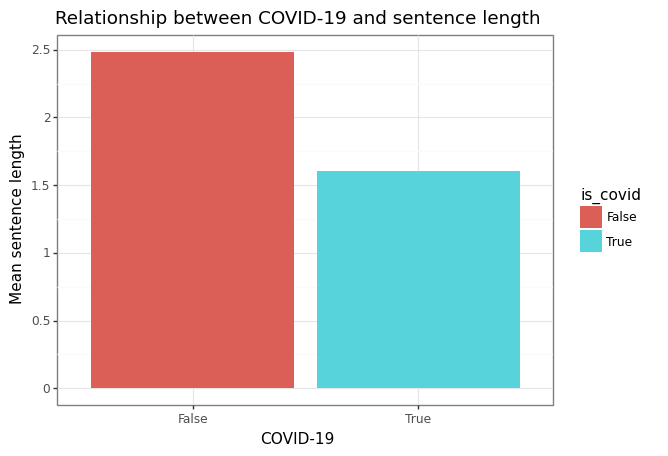

<ggplot: (8764797995132)>

In [247]:
ggplot(covid, aes(x='is_covid',y='mean_senlength',fill='is_covid')) +\
geom_col() +\
labs(title = 'Relationship between COVID-19 and sentence length', x = 'COVID-19', y = 'Mean sentence length')+\
theme_bw()

### Add livability index
Livability from website: https://www.areavibes.com/

In [20]:
new_df_con['Livability'] = [62, 51, 60, 56, 58, 64, 58, 56, 66, 55, 54, 57, 63, 68, 73, 73, 55, 63, 76, 76, 67, 69]
new_df_con.head()

,LAW_ENFORCEMENT_UNIT,COUNT,DISTRICT NAME,LATITUDE,LONGITUDE,NEIGHBORHOODS,Livability
0,District 11 - Harrison,10328,Harrison,41.873582,-87.705488,East Garfield Park,62
1,District 10 - Ogden,3393,Ogden,41.856685,-87.708382,North Lawndale,51
2,District 15 - Austin,3178,Austin,41.880083,-87.768200,Austin,60
3,District 7 - Englewood,2639,Englewood,41.779632,-87.660887,West Englewood,56
4,District 6 - Gresham,2329,Gresham,41.752137,-87.644229,Auburn Gresham,58


Merge them together

In [21]:
sentencing_cleaned2 = sentencing_cleaned1[(~sentencing_cleaned1.LAW_ENFORCEMENT_UNIT.isnull())&
                                         (~sentencing_cleaned1.arrest_year.isna())]
sentencing_conc = pd.merge(sentencing_cleaned2,
                            new_df_con[['Livability','LAW_ENFORCEMENT_UNIT']],
                            how='inner',
                            on='LAW_ENFORCEMENT_UNIT')
sentencing_conc.head()

,CASE_ID,CASE_PARTICIPANT_ID,RECEIVED_DATE,OFFENSE_CATEGORY,PRIMARY_CHARGE_FLAG,CHARGE_ID,CHARGE_VERSION_ID,DISPOSITION_CHARGED_OFFENSE_TITLE,CHARGE_COUNT,DISPOSITION_DATE,...,age_derived,sentenceymd_derived,sentenceym_derived,judgeid_derived,FN_judge,Gender_judge,is_judge_male,arrest_year,is_covid,Livability
0,377339554790,694908976813,4/20/2010 12:00:00 AM,Residential Burglary,True,333678120296,620028456139,RESIDENTIAL BURGLARY,1,8/17/2014 12:00:00 AM,...,20.0,2014-08-17,2014-08-01,judge_279,Shelley,female,False,2010.0,False,76
1,377483178659,695319307216,4/25/2010 12:00:00 AM,Vehicular Hijacking,True,333898177372,657484590678,ARMED ROBBERY,1,1/20/2012 12:00:00 AM,...,18.0,2012-01-20,2012-01-01,judge_334,William,male,True,2010.0,False,76
2,378092331838,697088125695,5/19/2010 12:00:00 AM,Narcotics,True,335399060145,623393931974,[POSSESSION OF CONTROLLED SUBSTANCE WITH INTEN...,1,7/10/2012 12:00:00 AM,...,38.0,2012-07-10,2012-07-01,judge_178,Lawrence,male,True,2010.0,False,76
3,378609260283,698663575500,6/14/2010 12:00:00 AM,Narcotics,True,336236855694,624986192074,POSSESSION OF A CONTROLLED SUBSTANCE,1,2/27/2012 12:00:00 AM,...,23.0,2012-02-27,2012-02-01,judge_279,Shelley,female,False,2010.0,False,76
4,379857965557,702470456396,8/11/2010 12:00:00 AM,Burglary,True,337103911746,626633943991,BURGLARY,1,2/8/2012 12:00:00 AM,...,24.0,2012-02-08,2012-02-01,judge_275,Sharon,female,False,2010.0,False,76


### Add Arrest police station history record index
In detailed, it refers to the proportion of different police station history record number

In [22]:
new_df_con['his_prop'] = new_df_con.COUNT / new_df_con.COUNT.sum()

In [23]:
new_df_con.head()

,LAW_ENFORCEMENT_UNIT,COUNT,DISTRICT NAME,LATITUDE,LONGITUDE,NEIGHBORHOODS,Livability,his_prop
0,District 11 - Harrison,10328,Harrison,41.873582,-87.705488,East Garfield Park,62,0.264049
1,District 10 - Ogden,3393,Ogden,41.856685,-87.708382,North Lawndale,51,0.086746
2,District 15 - Austin,3178,Austin,41.880083,-87.768200,Austin,60,0.081250
3,District 7 - Englewood,2639,Englewood,41.779632,-87.660887,West Englewood,56,0.067469
4,District 6 - Gresham,2329,Gresham,41.752137,-87.644229,Auburn Gresham,58,0.059544


In [24]:
sentencing_conc = pd.merge(sentencing_conc,
                            new_df_con[['his_prop','LAW_ENFORCEMENT_UNIT']],
                            how='inner',
                            on='LAW_ENFORCEMENT_UNIT')
sentencing_conc.head()

,CASE_ID,CASE_PARTICIPANT_ID,RECEIVED_DATE,OFFENSE_CATEGORY,PRIMARY_CHARGE_FLAG,CHARGE_ID,CHARGE_VERSION_ID,DISPOSITION_CHARGED_OFFENSE_TITLE,CHARGE_COUNT,DISPOSITION_DATE,...,sentenceymd_derived,sentenceym_derived,judgeid_derived,FN_judge,Gender_judge,is_judge_male,arrest_year,is_covid,Livability,his_prop
0,377339554790,694908976813,4/20/2010 12:00:00 AM,Residential Burglary,True,333678120296,620028456139,RESIDENTIAL BURGLARY,1,8/17/2014 12:00:00 AM,...,2014-08-17,2014-08-01,judge_279,Shelley,female,False,2010.0,False,76,0.015877
1,377483178659,695319307216,4/25/2010 12:00:00 AM,Vehicular Hijacking,True,333898177372,657484590678,ARMED ROBBERY,1,1/20/2012 12:00:00 AM,...,2012-01-20,2012-01-01,judge_334,William,male,True,2010.0,False,76,0.015877
2,378092331838,697088125695,5/19/2010 12:00:00 AM,Narcotics,True,335399060145,623393931974,[POSSESSION OF CONTROLLED SUBSTANCE WITH INTEN...,1,7/10/2012 12:00:00 AM,...,2012-07-10,2012-07-01,judge_178,Lawrence,male,True,2010.0,False,76,0.015877
3,378609260283,698663575500,6/14/2010 12:00:00 AM,Narcotics,True,336236855694,624986192074,POSSESSION OF A CONTROLLED SUBSTANCE,1,2/27/2012 12:00:00 AM,...,2012-02-27,2012-02-01,judge_279,Shelley,female,False,2010.0,False,76,0.015877
4,379857965557,702470456396,8/11/2010 12:00:00 AM,Burglary,True,337103911746,626633943991,BURGLARY,1,2/8/2012 12:00:00 AM,...,2012-02-08,2012-02-01,judge_275,Sharon,female,False,2010.0,False,76,0.015877


### Add senlength (unit: year) variable

In [25]:
sentencing_conc = sentencing_conc[(~sentencing_conc.COMMITMENT_TERM.isna())
                                     & (sentencing_conc.COMMITMENT_UNIT.isin(['Days','Hours','Year(s)','Months','Weeks','Natural Life']))]

In [26]:
# Change the units to year
def transition(df: pd.DataFrame):
    df['senlength_derived'] = [float(u)
      if v == 'Year(s)'
      else float(float(u) / (24*365)) 
           if v == 'Hours'
           else float(float(u)/ 365) 
                if v == 'Days'
                else float(float(u)/ 12) 
                    if v == 'Months'
                    else float(float(u) *7 / 365) 
                        if v == 'Weeks'
                        else float(100-20)
                               if (v == 'Natural Life') & (np.isnan(i))
                               else float(100-float(i)) 
      for u,v,i in zip(df.COMMITMENT_TERM,df.COMMITMENT_UNIT,df.age_derived)]
    
    return df

In [27]:
sentencing_conc1 = transition(df = sentencing_conc)
sentencing_conc1.head()

,CASE_ID,CASE_PARTICIPANT_ID,RECEIVED_DATE,OFFENSE_CATEGORY,PRIMARY_CHARGE_FLAG,CHARGE_ID,CHARGE_VERSION_ID,DISPOSITION_CHARGED_OFFENSE_TITLE,CHARGE_COUNT,DISPOSITION_DATE,...,sentenceym_derived,judgeid_derived,FN_judge,Gender_judge,is_judge_male,arrest_year,is_covid,Livability,his_prop,senlength_derived
0,377339554790,694908976813,4/20/2010 12:00:00 AM,Residential Burglary,True,333678120296,620028456139,RESIDENTIAL BURGLARY,1,8/17/2014 12:00:00 AM,...,2014-08-01,judge_279,Shelley,female,False,2010.0,False,76,0.015877,6.0
1,377483178659,695319307216,4/25/2010 12:00:00 AM,Vehicular Hijacking,True,333898177372,657484590678,ARMED ROBBERY,1,1/20/2012 12:00:00 AM,...,2012-01-01,judge_334,William,male,True,2010.0,False,76,0.015877,21.0
2,378092331838,697088125695,5/19/2010 12:00:00 AM,Narcotics,True,335399060145,623393931974,[POSSESSION OF CONTROLLED SUBSTANCE WITH INTEN...,1,7/10/2012 12:00:00 AM,...,2012-07-01,judge_178,Lawrence,male,True,2010.0,False,76,0.015877,2.0
3,378609260283,698663575500,6/14/2010 12:00:00 AM,Narcotics,True,336236855694,624986192074,POSSESSION OF A CONTROLLED SUBSTANCE,1,2/27/2012 12:00:00 AM,...,2012-02-01,judge_279,Shelley,female,False,2010.0,False,76,0.015877,1.0
4,379857965557,702470456396,8/11/2010 12:00:00 AM,Burglary,True,337103911746,626633943991,BURGLARY,1,2/8/2012 12:00:00 AM,...,2012-02-01,judge_275,Sharon,female,False,2010.0,False,76,0.015877,2.0


### Add Incar variable
Judge by COMMITMENT_TYPE == 'Illinois Department of Corrections

In [28]:
sentencing_conc.COMMITMENT_TYPE.value_counts().head(5)

Illinois Department of Corrections       20010
Probation                                11142
710/410 Probation                         2280
Cook County Department of Corrections     1283
Intensive Probation Services               656
Name: COMMITMENT_TYPE, dtype: int64

In [29]:
sentencing_conc1['Incar'] = np.where(sentencing_conc1.COMMITMENT_TYPE == 'Illinois Department of Corrections', True , False)
sentencing_conc1.head()

,CASE_ID,CASE_PARTICIPANT_ID,RECEIVED_DATE,OFFENSE_CATEGORY,PRIMARY_CHARGE_FLAG,CHARGE_ID,CHARGE_VERSION_ID,DISPOSITION_CHARGED_OFFENSE_TITLE,CHARGE_COUNT,DISPOSITION_DATE,...,judgeid_derived,FN_judge,Gender_judge,is_judge_male,arrest_year,is_covid,Livability,his_prop,senlength_derived,Incar
0,377339554790,694908976813,4/20/2010 12:00:00 AM,Residential Burglary,True,333678120296,620028456139,RESIDENTIAL BURGLARY,1,8/17/2014 12:00:00 AM,...,judge_279,Shelley,female,False,2010.0,False,76,0.015877,6.0,True
1,377483178659,695319307216,4/25/2010 12:00:00 AM,Vehicular Hijacking,True,333898177372,657484590678,ARMED ROBBERY,1,1/20/2012 12:00:00 AM,...,judge_334,William,male,True,2010.0,False,76,0.015877,21.0,True
2,378092331838,697088125695,5/19/2010 12:00:00 AM,Narcotics,True,335399060145,623393931974,[POSSESSION OF CONTROLLED SUBSTANCE WITH INTEN...,1,7/10/2012 12:00:00 AM,...,judge_178,Lawrence,male,True,2010.0,False,76,0.015877,2.0,False
3,378609260283,698663575500,6/14/2010 12:00:00 AM,Narcotics,True,336236855694,624986192074,POSSESSION OF A CONTROLLED SUBSTANCE,1,2/27/2012 12:00:00 AM,...,judge_279,Shelley,female,False,2010.0,False,76,0.015877,1.0,True
4,379857965557,702470456396,8/11/2010 12:00:00 AM,Burglary,True,337103911746,626633943991,BURGLARY,1,2/8/2012 12:00:00 AM,...,judge_275,Sharon,female,False,2010.0,False,76,0.015877,2.0,False


In [238]:
incar = sentencing_conc1.groupby('Incar').agg(mean_senlength = ('senlength_derived', 'mean')).reset_index()
incar

,Incar,mean_senlength
0,False,1.800948
1,True,3.052360


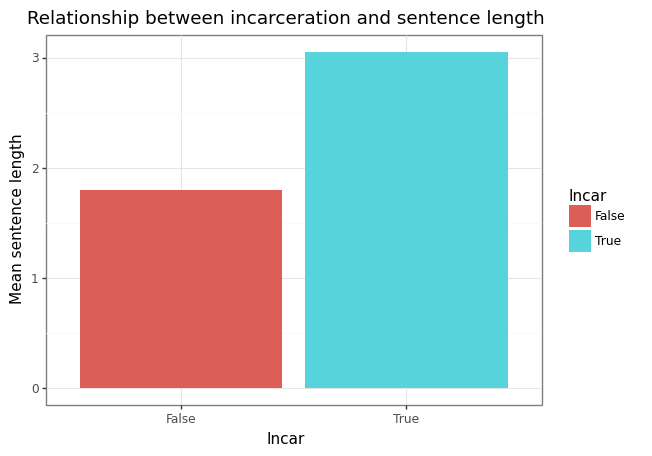

<ggplot: (8764797989723)>

In [242]:
ggplot(incar, aes(x='Incar',y='mean_senlength',fill='Incar')) +\
geom_col() +\
labs(title = 'Relationship between incarceration and sentence length', x = 'Incar', y = 'Mean sentence length')+\
theme_bw()

### Rename the column with value of True/False as dummy variable (0/1)

In [97]:
sentencing_concat = sentencing_conc1[['is_changed_offense','is_black_derived','is_hisp_derived'\
                                         ,'is_white_derived','is_male_derived','is_judge_male',\
                                      'is_covid','Livability','his_prop','Incar','senlength_derived']]
sentencing_concat.head()

,is_changed_offense,is_black_derived,is_hisp_derived,is_white_derived,is_male_derived,is_judge_male,is_covid,Livability,his_prop,Incar,senlength_derived
0,False,False,True,False,True,False,False,76,0.015877,True,6.0
1,False,True,False,False,True,True,False,76,0.015877,True,21.0
2,False,False,False,False,True,True,False,76,0.015877,False,2.0
3,False,True,False,False,True,False,False,76,0.015877,True,1.0
4,False,False,True,False,True,False,False,76,0.015877,False,2.0


In [98]:
def tran(a):
    sentencing_concat[a] = (sentencing_concat[a]==True).astype(int)
    return sentencing_concat

In [99]:
for i in ['is_changed_offense','is_black_derived','is_hisp_derived'\
                                         ,'is_white_derived','is_male_derived','is_judge_male',\
                                      'is_covid','Incar']:
    sentencing_concat = tran(i)

In [100]:
sentencing_concat.head()

,is_changed_offense,is_black_derived,is_hisp_derived,is_white_derived,is_male_derived,is_judge_male,is_covid,Livability,his_prop,Incar,senlength_derived
0,0,0,1,0,1,0,0,76,0.015877,1,6.0
1,0,1,0,0,1,1,0,76,0.015877,1,21.0
2,0,0,0,0,1,1,0,76,0.015877,0,2.0
3,0,1,0,0,1,0,0,76,0.015877,1,1.0
4,0,0,1,0,1,0,0,76,0.015877,0,2.0


In [101]:
sentencing_concat.describe()

,is_changed_offense,is_black_derived,is_hisp_derived,is_white_derived,is_male_derived,is_judge_male,is_covid,Livability,his_prop,Incar,senlength_derived
count,36978.000000,36978.000000,36978.000000,36978.000000,36978.000000,36978.000000,36978.000000,36978.00000,36978.000000,36978.000000,36978.000000
mean,0.042944,0.794743,0.133025,0.067932,0.895235,0.721889,0.003975,60.19974,0.106220,0.541133,2.478128
std,0.202735,0.403895,0.339606,0.251633,0.306255,0.448075,0.062926,5.49458,0.095808,0.498312,3.455747
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,51.00000,0.001253,0.000000,0.000000
25%,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,56.00000,0.037506,0.000000,1.250000
50%,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,60.00000,0.059544,1.000000,2.000000
75%,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,62.00000,0.264049,1.000000,2.500000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,76.00000,0.264049,1.000000,364.000000


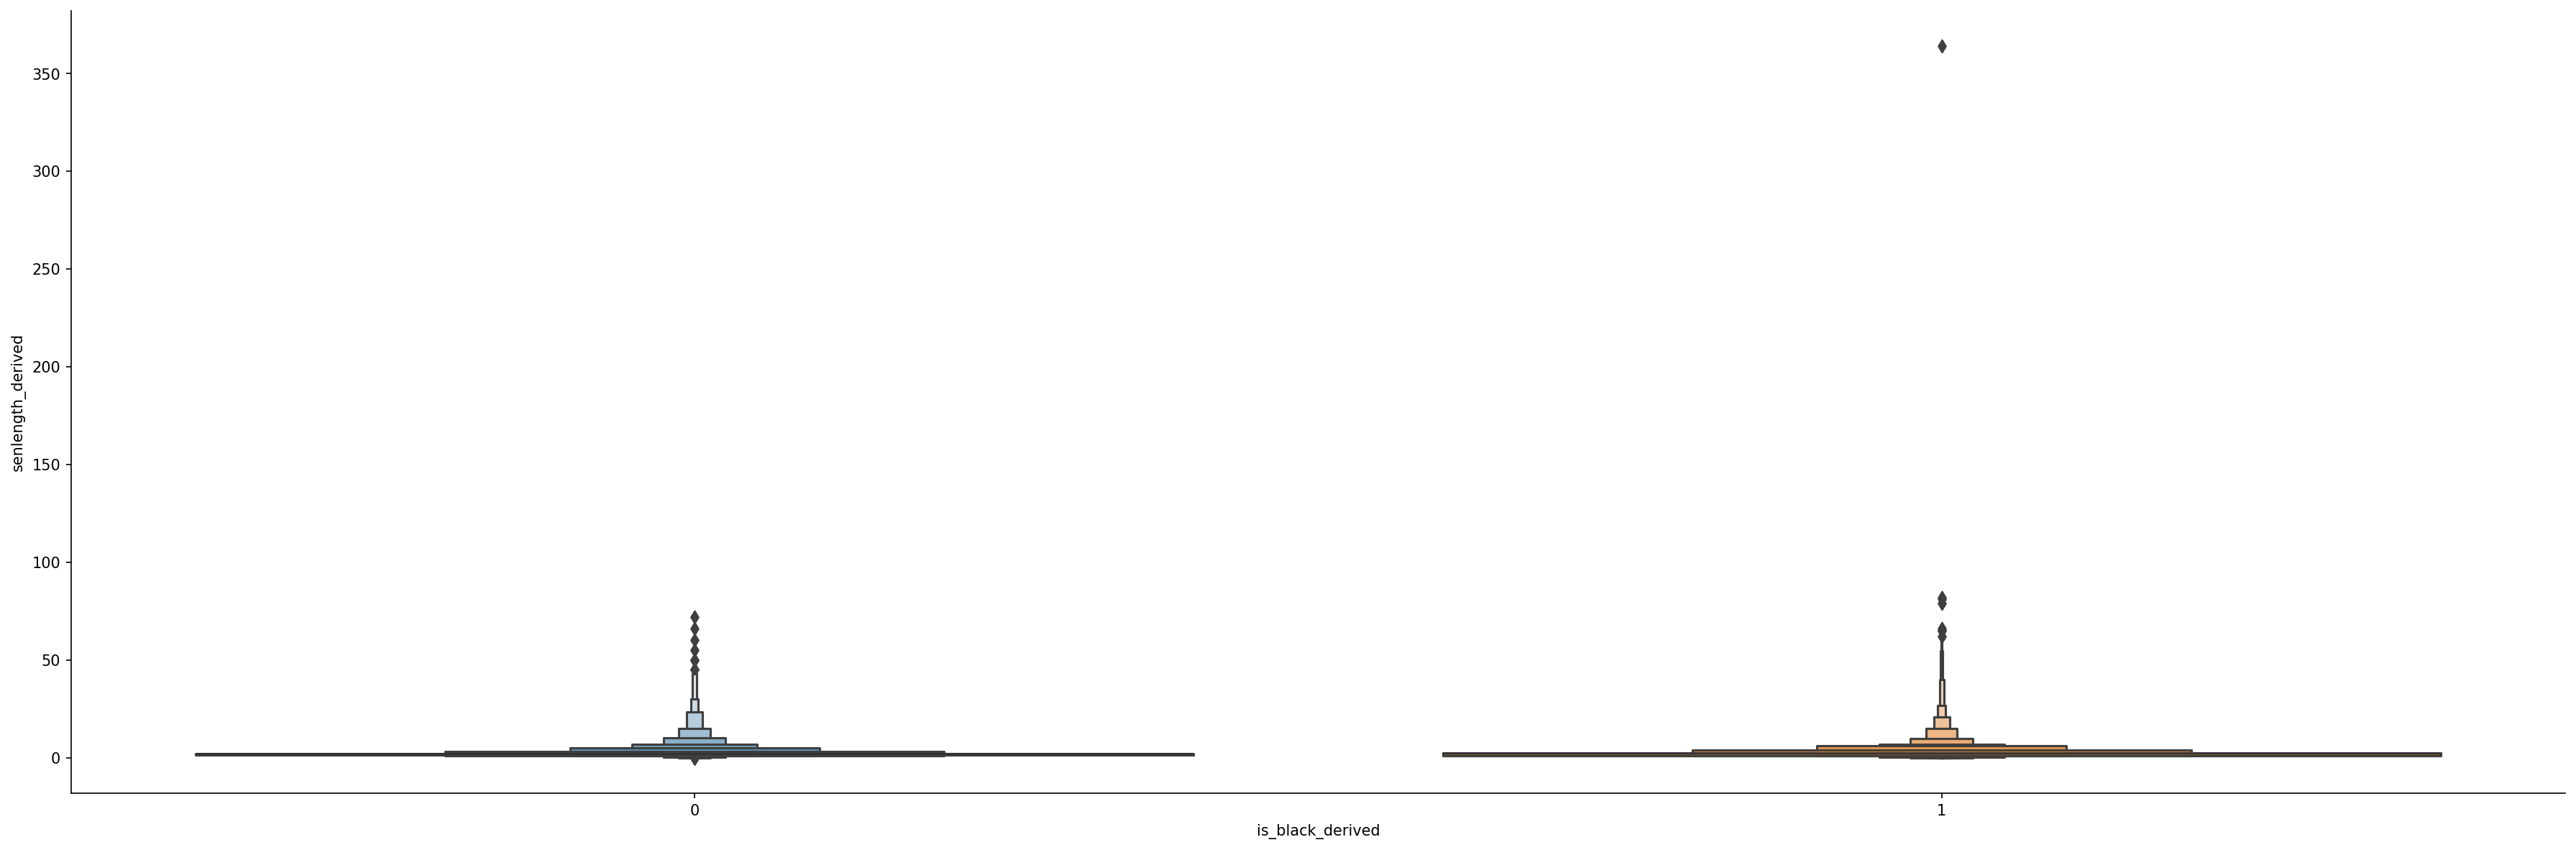

In [102]:
## The relation between race and senlength 
g = sns.catplot(y = "senlength_derived", 
                x = "is_black_derived",
                data = sentencing_concat,
                kind="boxen", 
                height = 8, 
                aspect = 3)
g.fig.set_dpi(150)

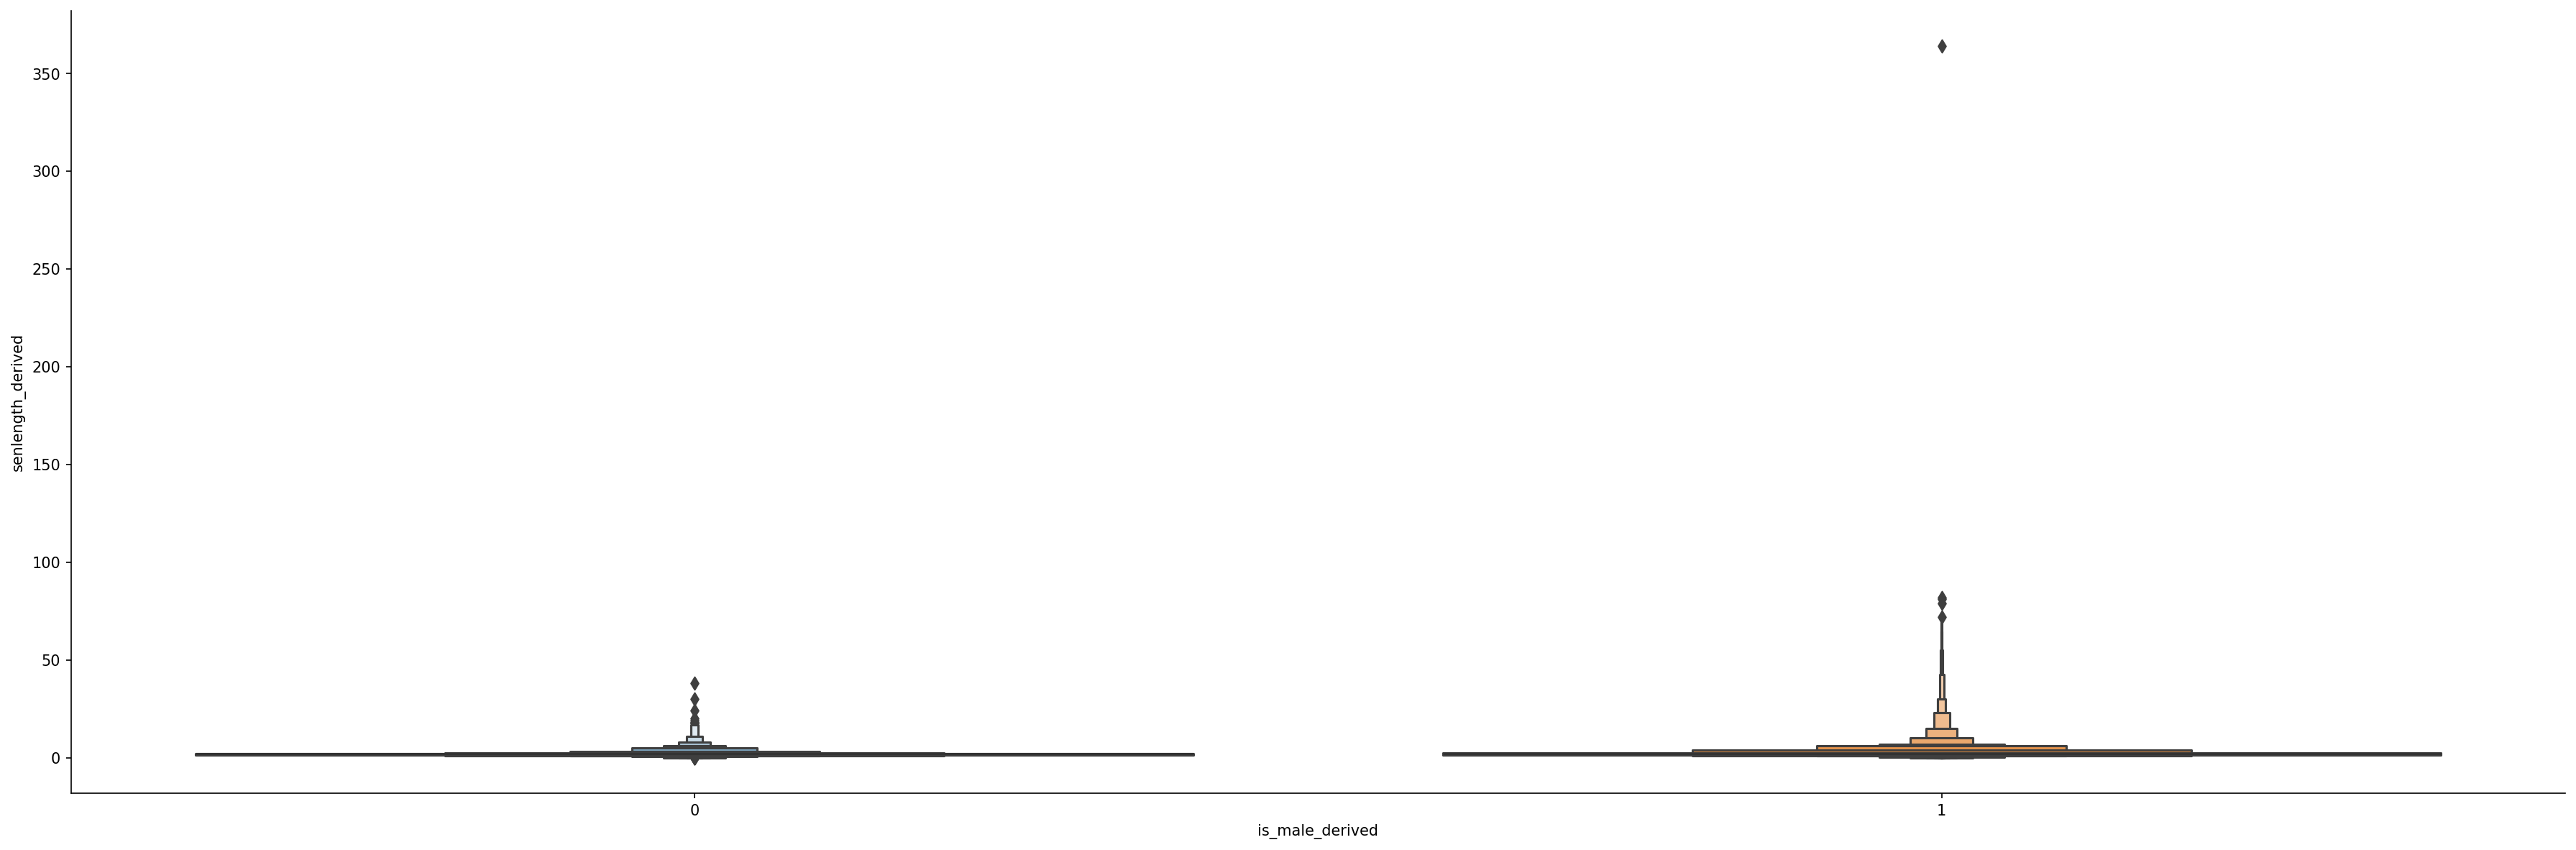

In [103]:
## The relation between gender and senlength
g = sns.catplot(y = "senlength_derived", 
                x = "is_male_derived",
                data = sentencing_concat,
                kind="boxen", 
                height = 8, 
                aspect = 3)
g.fig.set_dpi(150)

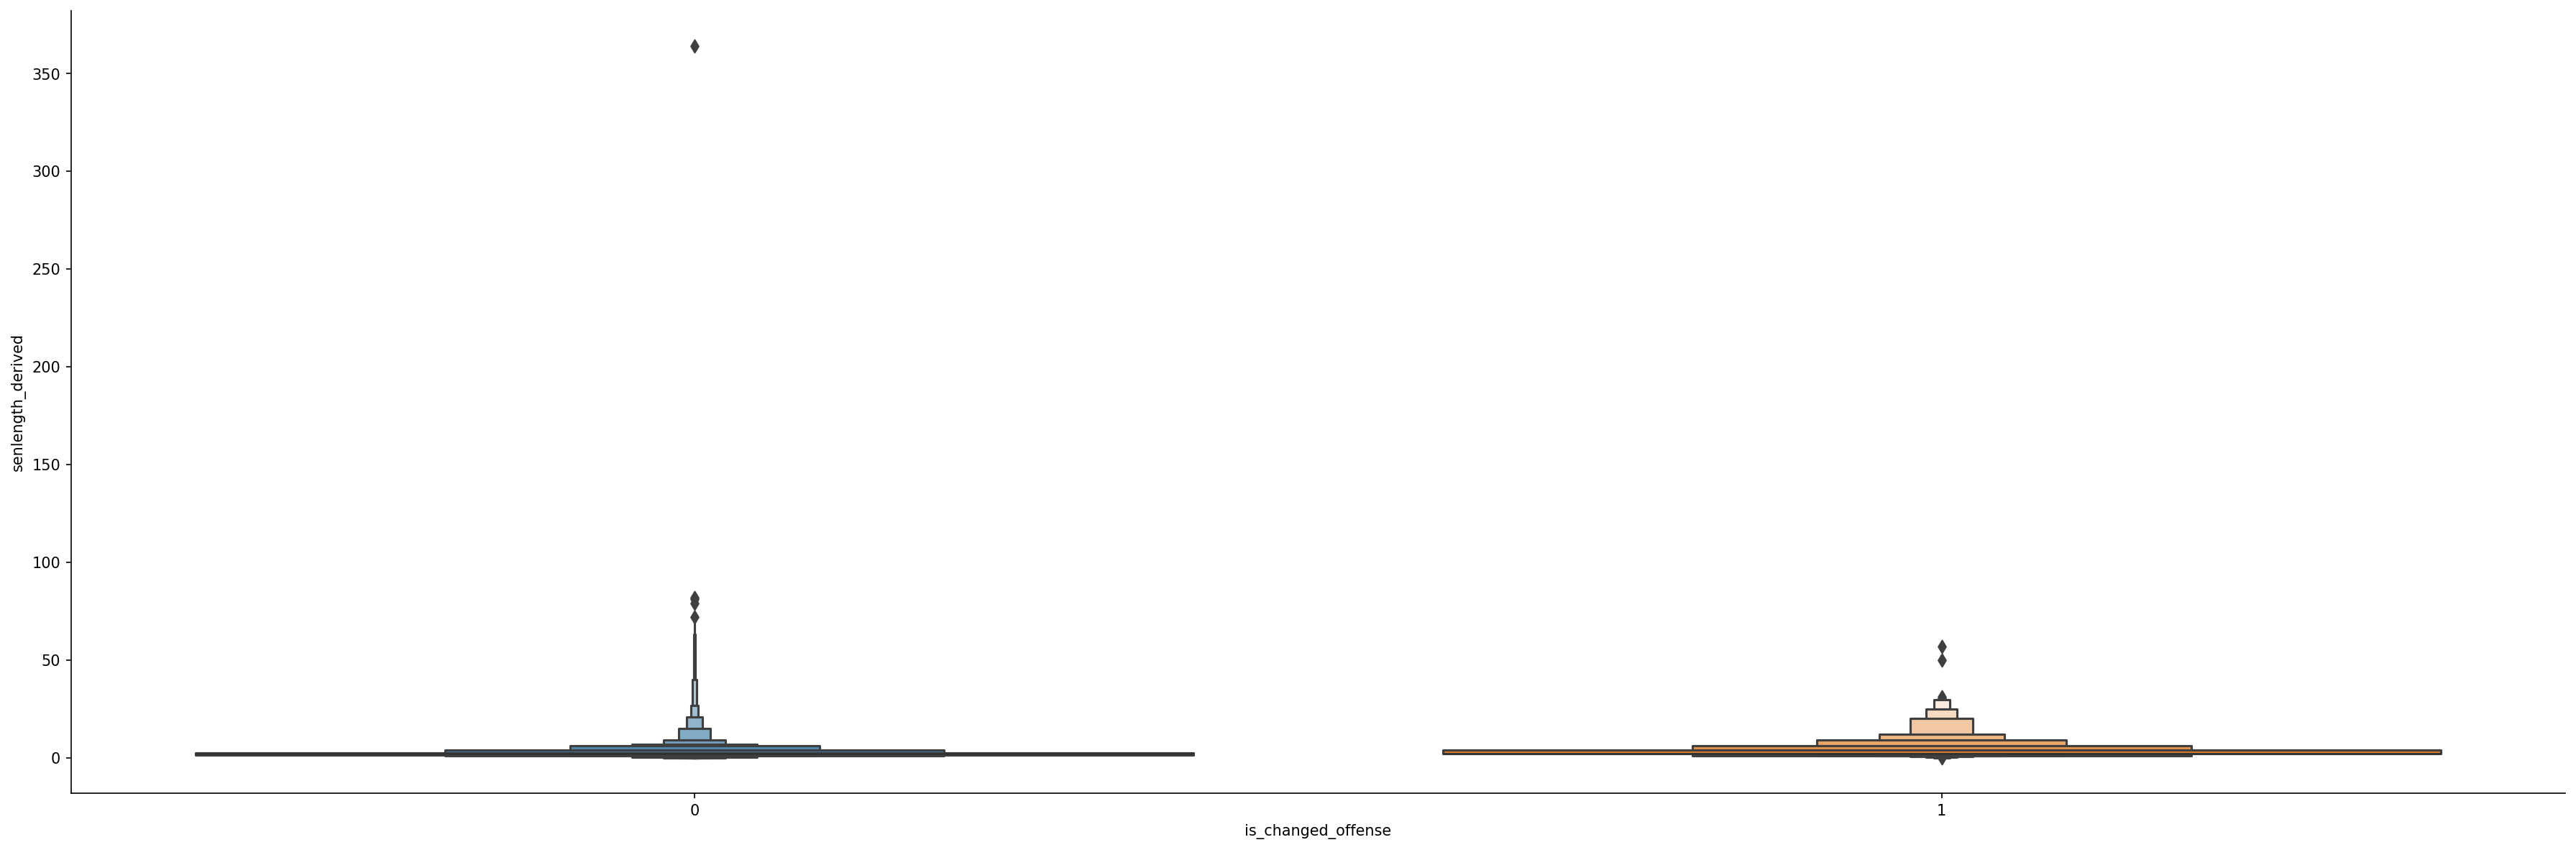

In [104]:
## The relation between changed_offense and senlength
g = sns.catplot(y = "senlength_derived", 
                x = "is_changed_offense",
                data = sentencing_concat,
                kind="boxen", 
                height = 8, 
                aspect = 3)
g.fig.set_dpi(150)

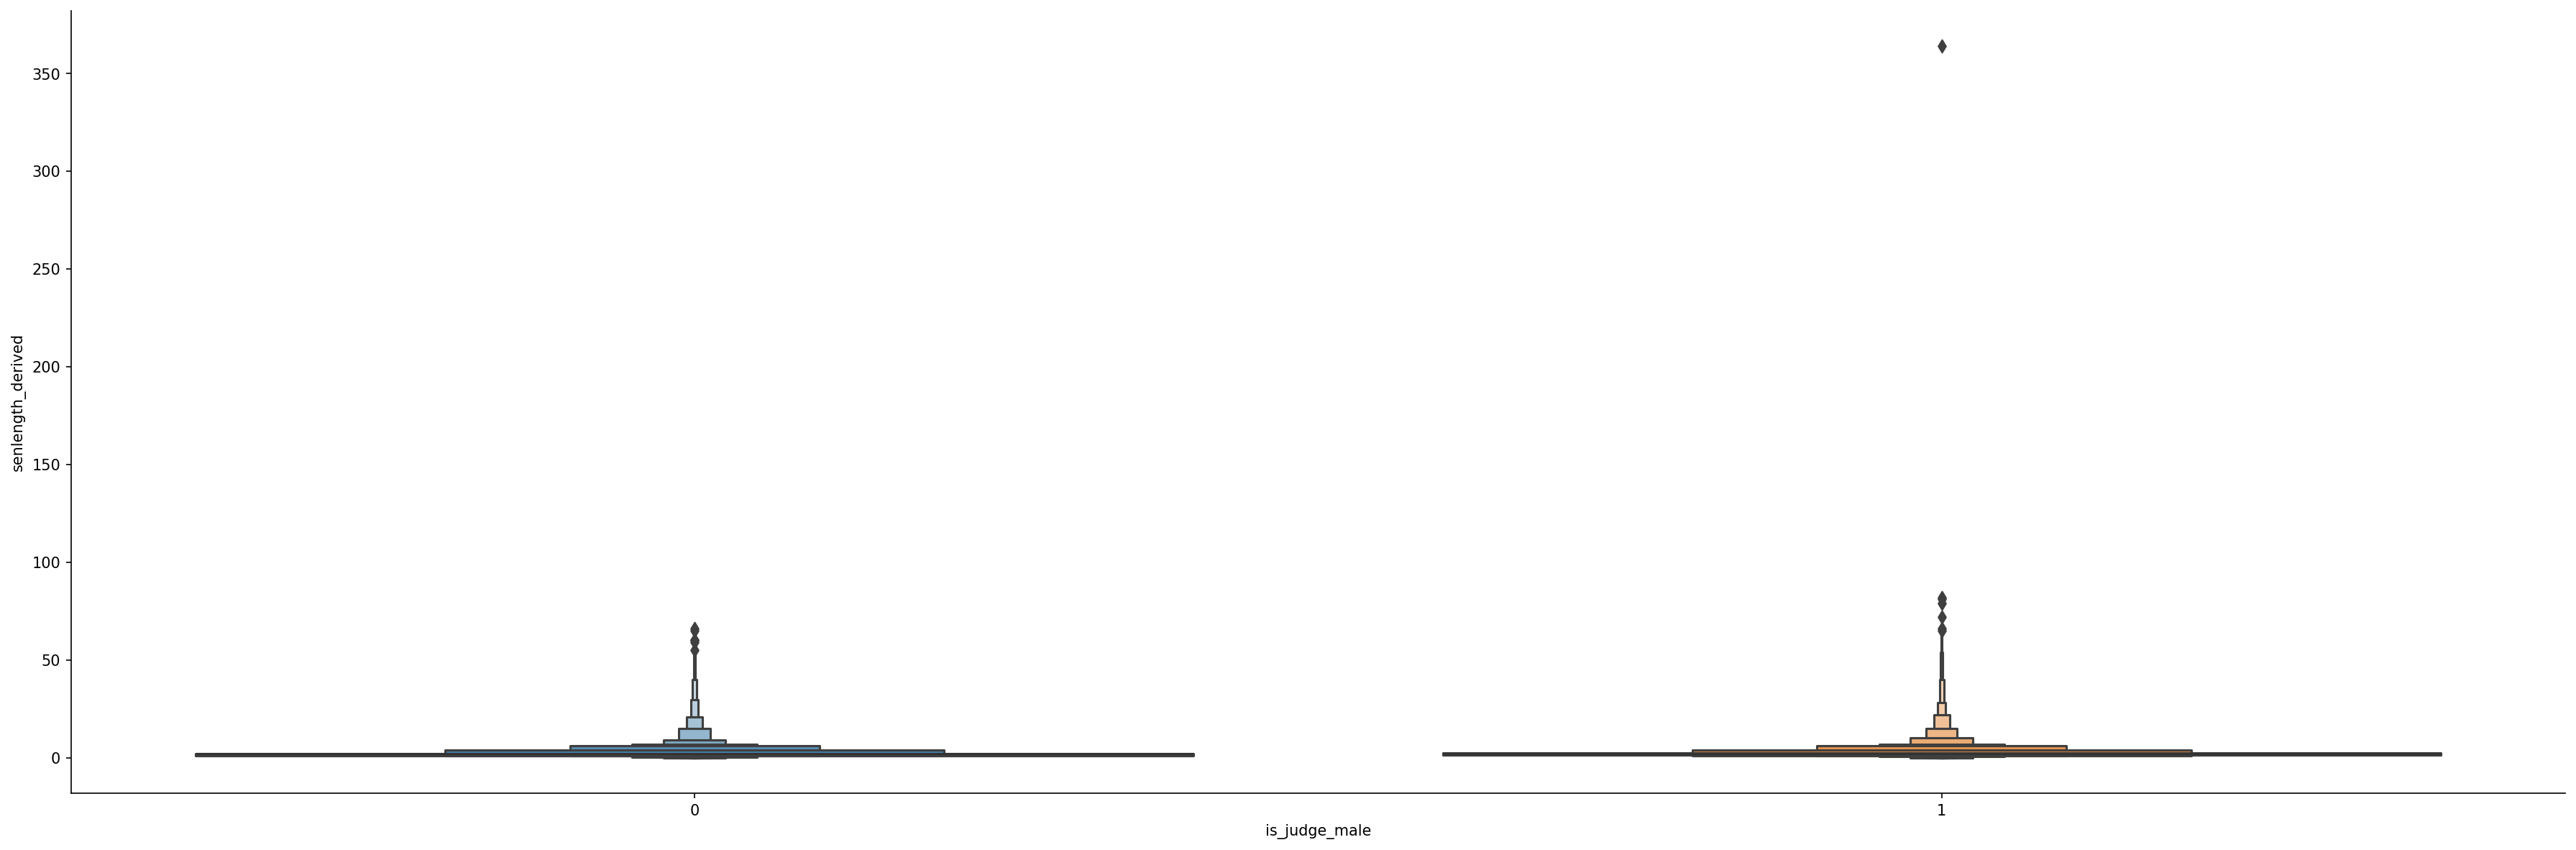

In [105]:
## The relation between judge's gender and senlength
g = sns.catplot(y = "senlength_derived", 
                x = "is_judge_male",
                data = sentencing_concat,
                kind="boxen", 
                height = 8, 
                aspect = 3)
g.fig.set_dpi(150)

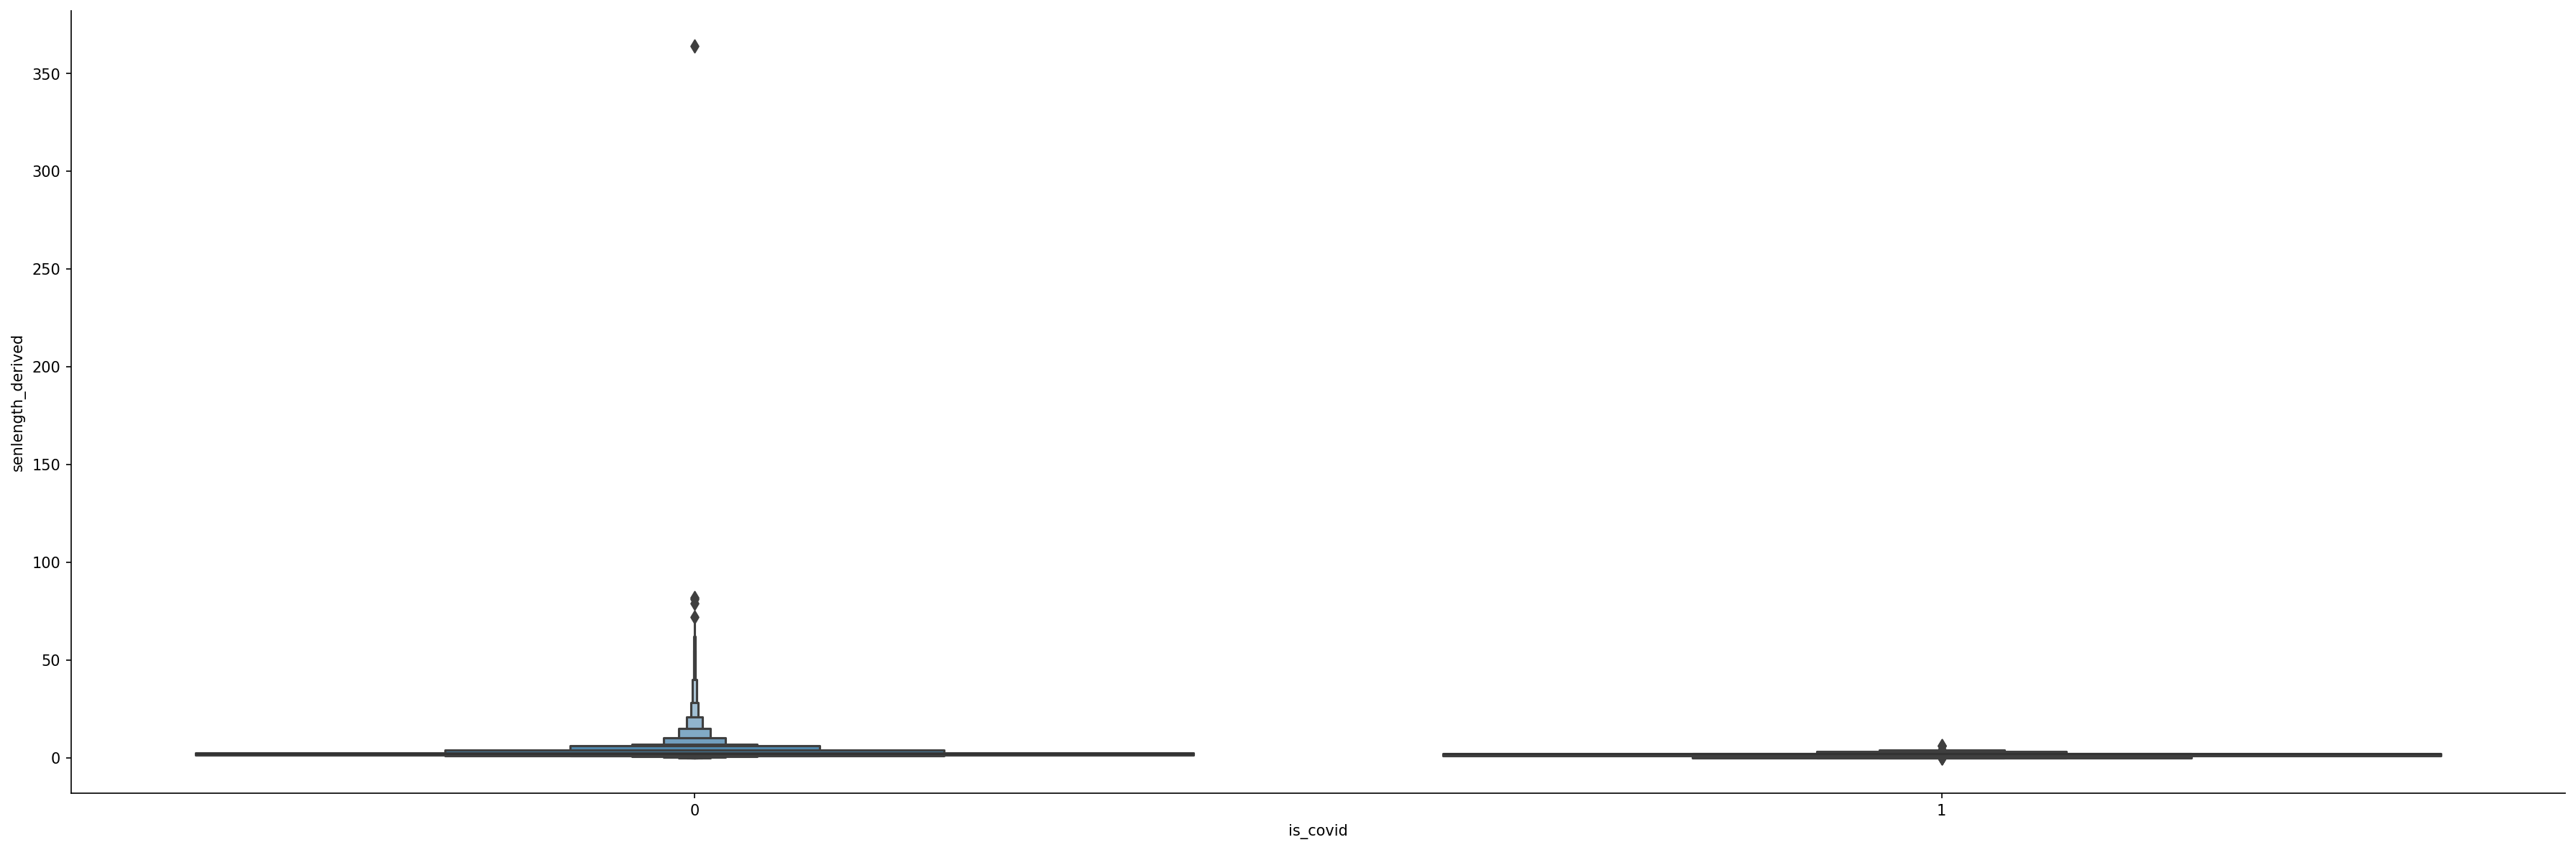

In [106]:
## The relation between covid and senlength
g = sns.catplot(y = "senlength_derived", 
                x = "is_covid",
                data = sentencing_concat,
                kind="boxen", 
                height = 8, 
                aspect = 3)
g.fig.set_dpi(150)

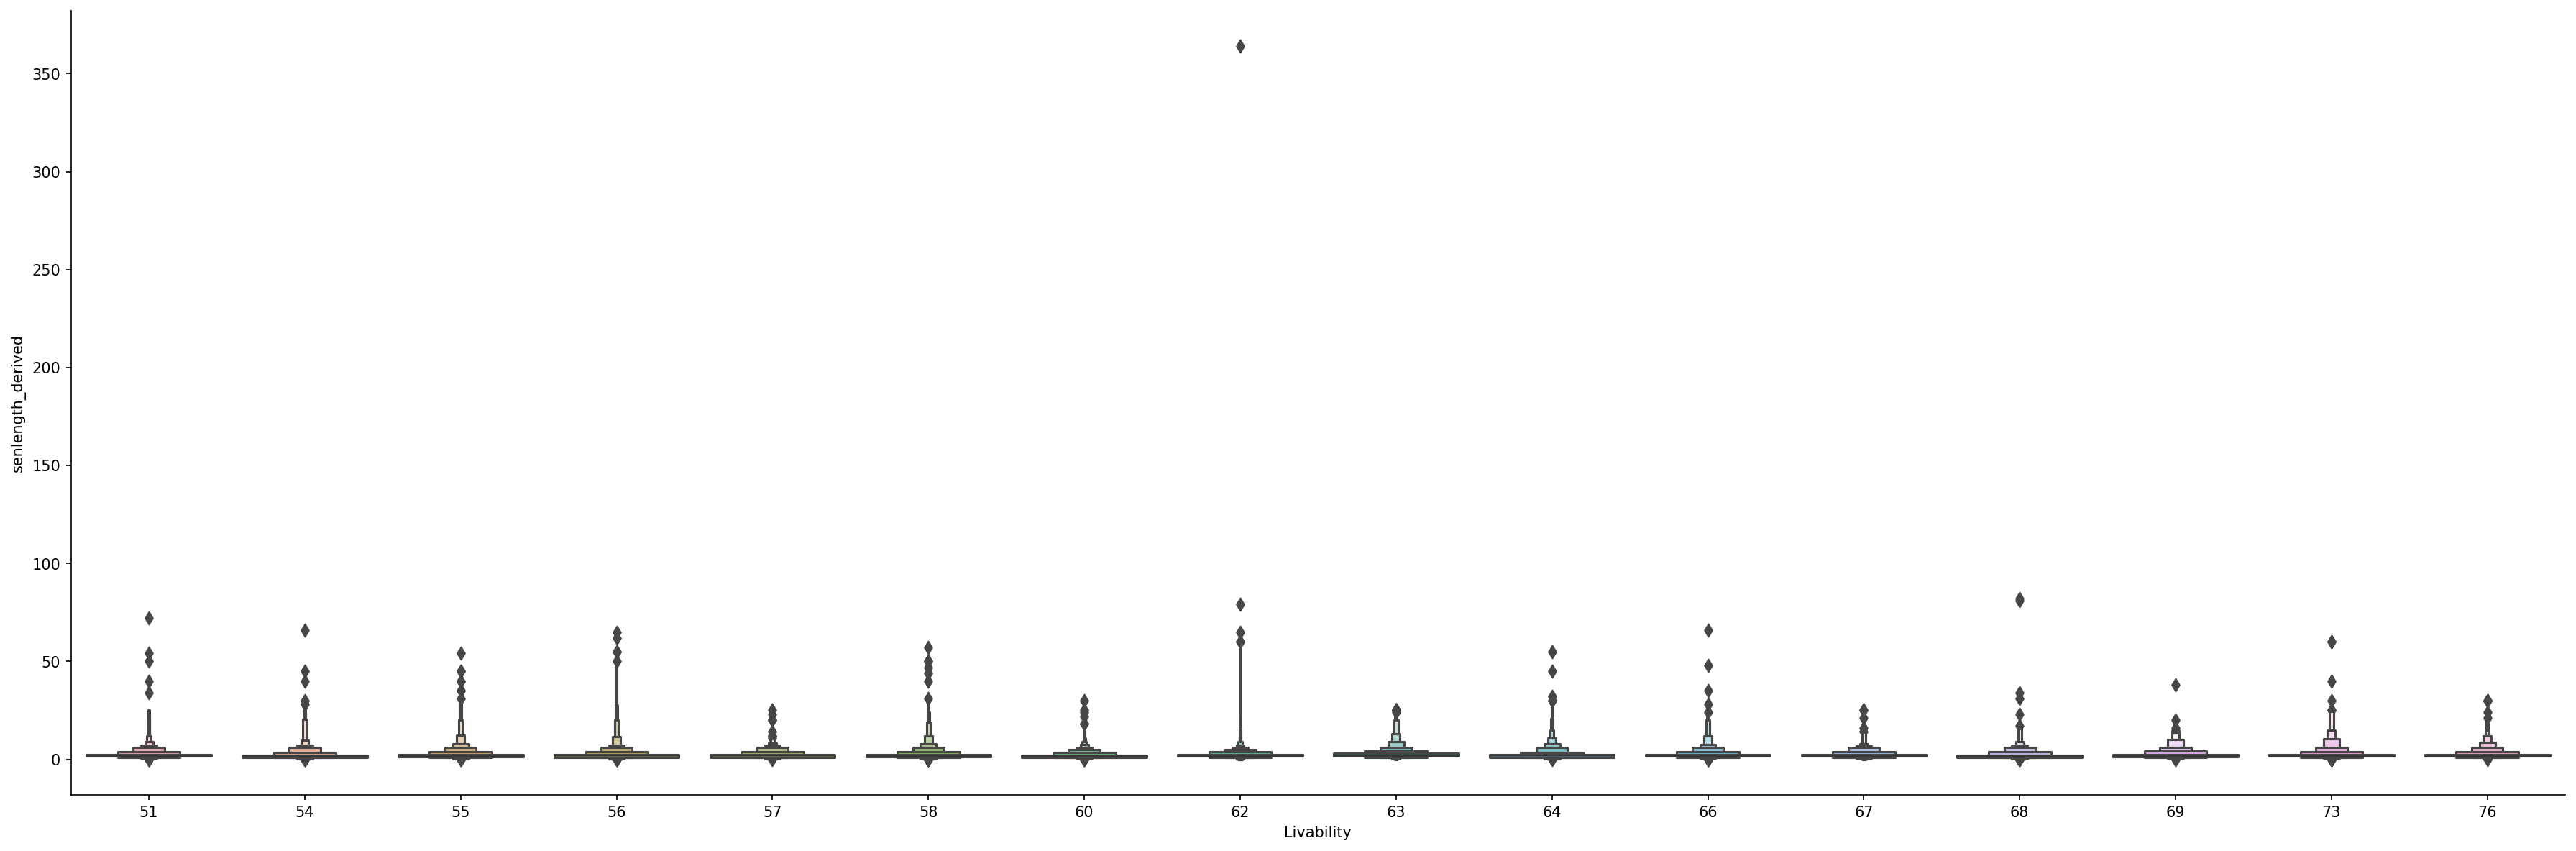

In [107]:
## The relation between livability of neighborhood and senlength
g = sns.catplot(y = "senlength_derived", 
                x = "Livability",
                data = sentencing_concat,
                kind="boxen", 
                height = 8, 
                aspect = 3)
g.fig.set_dpi(150)

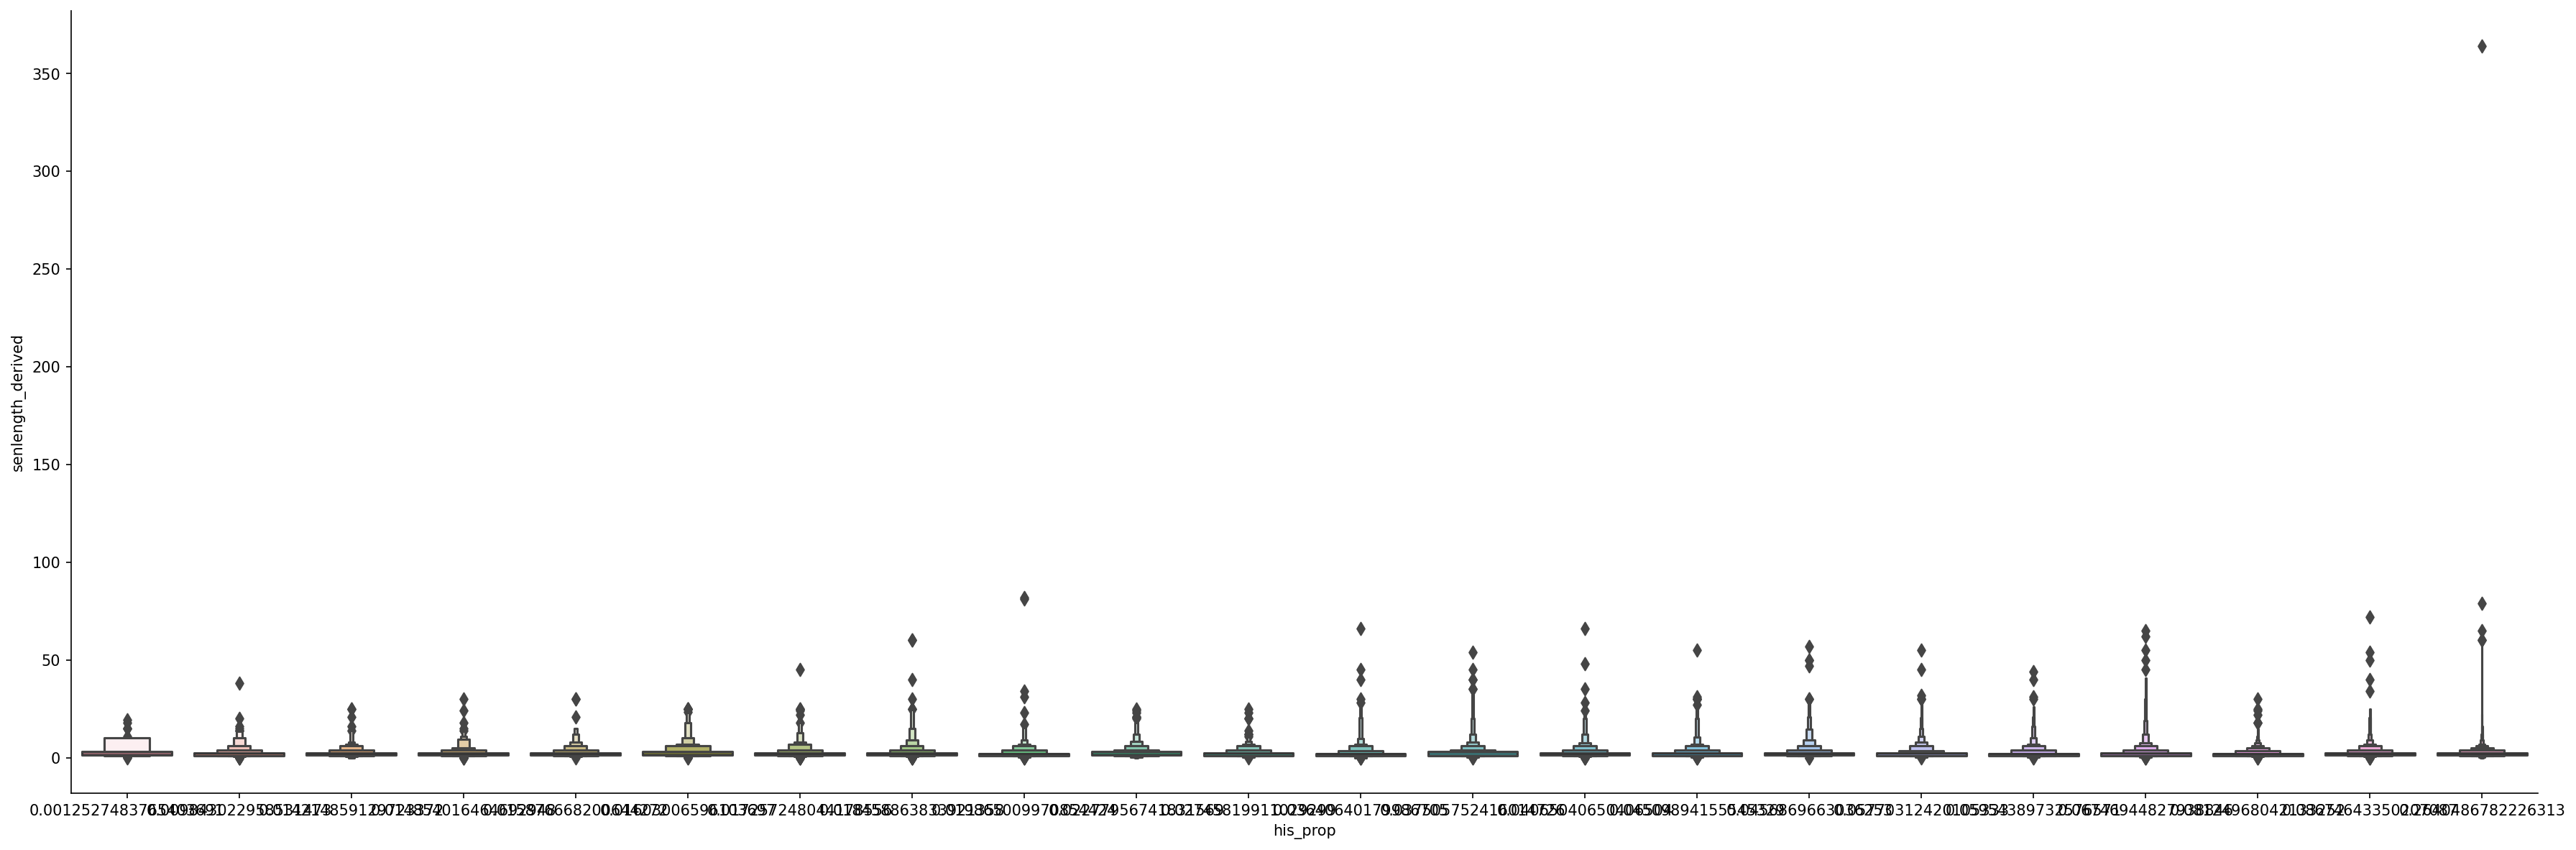

In [108]:
## The relation between the history sentence proportion and senlength
g = sns.catplot(y = "senlength_derived", 
                x = "his_prop",
                data = sentencing_concat,
                kind="boxen", 
                height = 8, 
                aspect = 3)
g.fig.set_dpi(150)

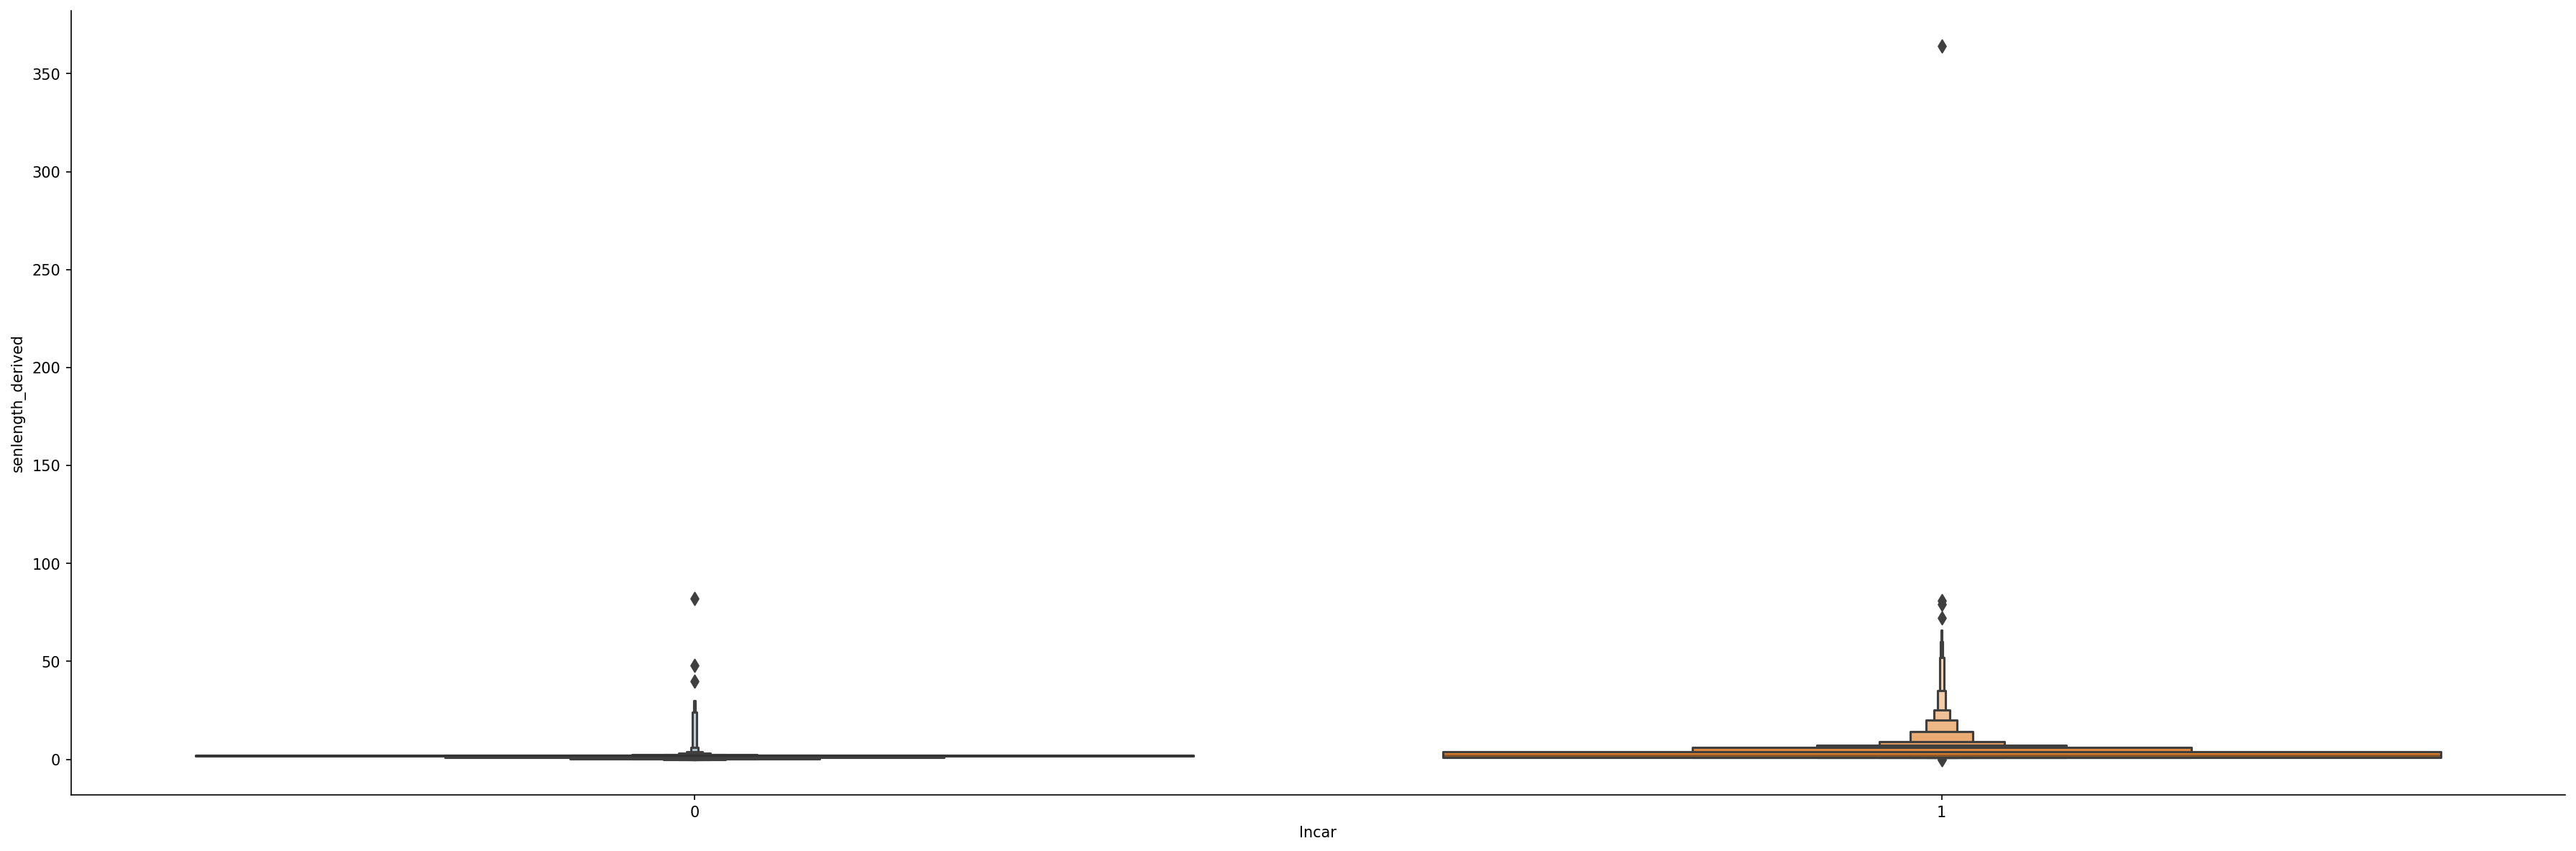

In [109]:
## The relation between incarcerated and senlength
g = sns.catplot(y = "senlength_derived", 
                x = "Incar",
                data = sentencing_concat,
                kind="boxen", 
                height = 8, 
                aspect = 3)
g.fig.set_dpi(150)

## Linear Regression Model Results

In [34]:
## Get y_variable
y = pd.DataFrame(sentencing_concat.senlength_derived)
## Get X variable
X = pd.DataFrame(sentencing_concat.drop(['senlength_derived'], axis = 1))

In [35]:
## Add constant of X variable
import statsmodels.api as sm
X = sm.add_constant(X)

## Train the model
model = sm.OLS(y, X).fit()
## See the regression results
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:      senlength_derived   R-squared:                       0.039
Model:                            OLS   Adj. R-squared:                  0.038
Method:                 Least Squares   F-statistic:                     148.3
Date:                Wed, 23 Nov 2022   Prob (F-statistic):          2.41e-306
Time:                        21:42:20   Log-Likelihood:                -97596.
No. Observations:               36978   AIC:                         1.952e+05
Df Residuals:                   36967   BIC:                         1.953e+05
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  1.0456      0

We can see is_black_derived, is_hisp_derived, is_white_derived have no relevant with y variable, is_covid and Livability has less relevant with y variable.

### Plot the residual correlation of the model using one of the significant independent variables (Incar)

eval_env: 1


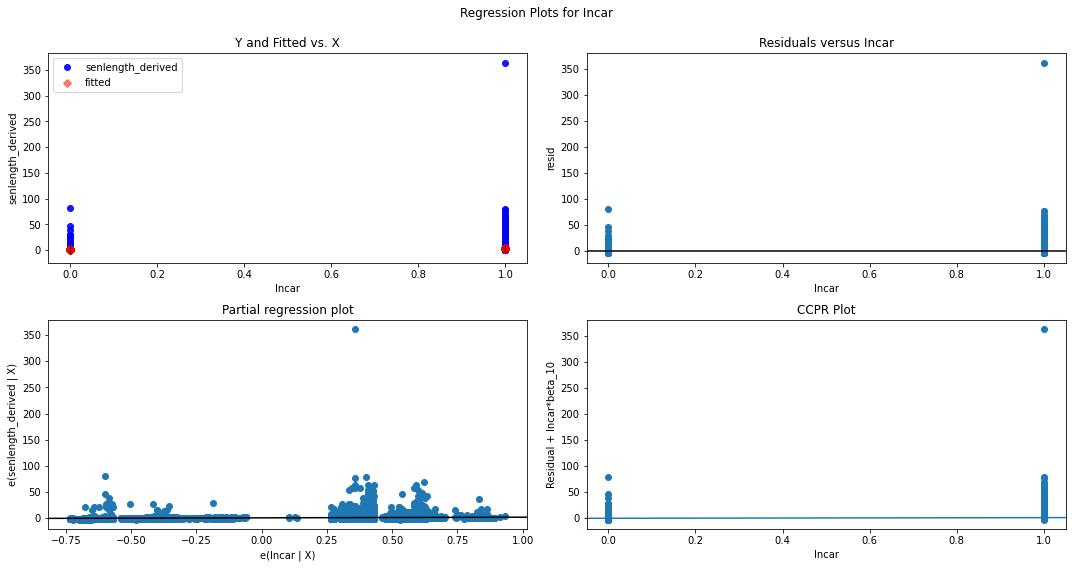

In [36]:
import matplotlib.pyplot as plt
import seaborn as sns
import warnings 
warnings.filterwarnings("ignore")

## The regression model was tested for CRIM variables
fig = plt.figure(figsize=(15,8))
fig = sm.graphics.plot_regress_exog(model,"Incar", fig =fig)

In [37]:
# Get the regression coefficient
model.params

const                 1.045606
is_changed_offense    0.965320
is_black_derived      0.175163
is_hisp_derived       0.291564
is_white_derived      0.070332
is_male_derived       0.177768
is_judge_male         0.144593
is_covid             -0.477214
Livability            0.006731
his_prop             -1.262022
Incar                 1.248345
dtype: float64

In [38]:
# Get the p-value
model.pvalues

const                  3.292154e-03
is_changed_offense     3.211862e-28
is_black_derived       5.186682e-01
is_hisp_derived        2.865593e-01
is_white_derived       7.998644e-01
is_male_derived        2.323591e-03
is_judge_male          2.475548e-04
is_covid               8.875191e-02
Livability             4.637482e-02
his_prop               4.109040e-11
Incar                 1.896402e-254
dtype: float64

In [39]:
# Summary of regression coefficient table
coef_df = pd.DataFrame({"params": model.params,   # Coefficient
                        "std err": model.bse,     # Standard deviation of regression coefficient
                        "t": round(model.tvalues,3),       # t-value
                        "p-values": round(model.pvalues,3) # P-value
                         })

coef_df[['coef_0.025','coef_0.975']] = model.conf_int() # The regression coefficient confidence interval defaults to 5%
coef_df

,params,std err,t,p-values,coef_0.025,coef_0.975
const,1.045606,0.355740,2.939,0.003,0.348346,1.742865
is_changed_offense,0.965320,0.087559,11.025,0.000,0.793702,1.136939
is_black_derived,0.175163,0.271399,0.645,0.519,-0.356788,0.707113
is_hisp_derived,0.291564,0.273585,1.066,0.287,-0.244671,0.827799
is_white_derived,0.070332,0.277417,0.254,0.800,-0.473413,0.614076
is_male_derived,0.177768,0.058368,3.046,0.002,0.063365,0.292172
is_judge_male,0.144593,0.039451,3.665,0.000,0.067268,0.221918
is_covid,-0.477214,0.280374,-1.702,0.089,-1.026755,0.072327
Livability,0.006731,0.003379,1.992,0.046,0.000108,0.013354
his_prop,-1.262022,0.191155,-6.602,0.000,-1.636691,-0.887352


senlength_derived = 0.96532*is_changed_offense + 0.175163*is_black_derived + 0.291564*is_hisp_derived + 0.070332*is_white_derived + 0.177768*is_male_derived + 0.144593*is_judge_male - 0.477214*is_covid + 0.006731*Livability - 1.262022*his_prop + 1.248345*Incar + 1.045606

In [40]:
# Model fitted values
model.fittedvalues.head()

0    3.254796
1    3.282987
2    1.859479
3    3.138394
4    2.006451
dtype: float64

In [41]:
# Model freedom (coefficient freedom)
model.df_model

10.0

In [42]:
# R-squared
model.rsquared

0.038559309884280246

In [43]:
# Adjusted R-squared
model.rsquared_adj

0.038299229085157815

## Test and compare different models to predict the sentence length according to the different variables

In [122]:
y = sentencing_concat.senlength_derived
X = sentencing_concat.drop(['senlength_derived'], axis = 1)
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,random_state=6) 

In [259]:
feature_list = list(X.columns)

In [181]:
## Describe the training and test shape
print('Training Features Shape:', X_train.shape)
print('Training Labels Shape:', y_train.shape)
print('Testing Features Shape:', X_test.shape)
print('Testing Labels Shape:', y_test.shape)

Training Features Shape: (27733, 10)
Training Labels Shape: (27733,)
Testing Features Shape: (9245, 10)
Testing Labels Shape: (9245,)


### Ridge Regression

In [118]:
params = {'alpha' : [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000, 100000]}
ridge_regressor = GridSearchCV(Ridge(), params, cv = 5, 
                               scoring = 'neg_mean_absolute_error',
                               n_jobs = -1)
ridge_regressor.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=Ridge(), n_jobs=-1,
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000,
                                   10000, 100000]},
             scoring='neg_mean_absolute_error')

In [156]:
## The predict value of test dataset
y_train_pred = ridge_regressor.predict(X_train)
y_test_pred = ridge_regressor.predict(X_test)
y_pre_df_ridge = pd.DataFrame(y_test_pred)
y_test_df = y_test.reset_index().drop(columns=['index'])
y_pre_df_ridge.columns = ['ridge']
pd.concat([y_test_df, y_pre_df_ridge],axis=1).head()

,senlength_derived,ridge
0,1.5,1.838394
1,2.0,3.002735
2,1.0,2.822862
3,1.0,2.866395
4,1.0,2.937738


In [125]:
## The result of train dataset
print("Train Results for Ridge Regressor Model:")
print("Root Mean Squared Error: ", sqrt(mse(y_train.values, y_train_pred)))
print("R-Squared: ", r2_score(y_train.values, y_train_pred))

Train Results for Ridge Regressor Model:
Root Mean Squared Error:  2.8164648506113035
R-Squared:  0.05040277086826339


In [ ]:
## The result of test dataset
print("Test Results for Ridge Regressor Model:")
print("Root Mean Squared Error: ", sqrt(mse(y_test, y_test_pred)))
print("R-Squared: ", r2_score(y_test, y_test_pred))

### Lasso Model

In [147]:
from sklearn.linear_model import Lasso
params = {'alpha' : [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000, 100000]}
lasso_regressor = GridSearchCV(Lasso(), params , cv = 15,
                               scoring = 'neg_mean_absolute_error', 
                               n_jobs = -1)
lasso_regressor.fit(X_train, y_train)

GridSearchCV(cv=15, estimator=Lasso(), n_jobs=-1,
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000,
                                   10000, 100000]},
             scoring='neg_mean_absolute_error')

In [213]:
y_train_pred = lasso_regressor.predict(X_train)
y_test_pred = lasso_regressor.predict(X_test)
y_pre_df_lasso = pd.DataFrame(y_test_pred)
y_test_df = y_test.reset_index().drop(columns=['index'])
y_pre_df_lasso.columns = ['lasso']
pd.concat([y_test_df, y_pre_df_lasso],axis=1).head()

,senlength_derived,lasso
0,1.5,2.023137
1,2.0,2.848288
2,1.0,2.848288
3,1.0,2.848288
4,1.0,2.848288


In [214]:
## The result of train dataset
print("Train Results for Lasso Regressor Model:")
print("Root Mean Squared Error: ", sqrt(mse(y_train.values, y_train_pred)))
print("R-Squared: ", r2_score(y_train.values, y_train_pred))

Train Results for Lasso Regressor Model:
Root Mean Squared Error:  2.831860527558309
R-Squared:  0.039992806001035164


In [215]:
## The result of test dataset
print("Test Results for Lasso Regressor Model:")
print("Root Mean Squared Error: ", sqrt(mse(y_test, y_test_pred)))
print("R-Squared: ", r2_score(y_test, y_test_pred))

Test Results for Lasso Regressor Model:
Root Mean Squared Error:  4.7258543500189285
R-Squared:  0.016366983205232888


### ElasticNet Model

In [169]:
from sklearn.linear_model import ElasticNet
params = {'alpha' : [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000, 100000]}
elastic_regressor = GridSearchCV(ElasticNet(), params, cv = 15, 
                               scoring = 'neg_mean_absolute_error',
                               n_jobs = -1)
elastic_regressor.fit(X_train, y_train)

GridSearchCV(cv=15, estimator=ElasticNet(), n_jobs=-1,
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000,
                                   10000, 100000]},
             scoring='neg_mean_absolute_error')

In [207]:
y_train_pred = elastic_regressor.predict(X_train)
y_test_pred = elastic_regressor.predict(X_test)
y_pre_df_elastic = pd.DataFrame(y_test_pred)
y_test_df = y_test.reset_index().drop(columns=['index'])
y_pre_df_elastic.columns = ['elastic']
pd.concat([y_test_df, y_pre_df_elastic],axis=1).head()

,senlength_derived,elastic
0,1.5,2.012676
1,2.0,2.867361
2,1.0,2.855766
3,1.0,2.855766
4,1.0,2.864462


In [208]:
## The result of train dataset
print("Train Results for ElasticNet Regressor Model:")
print("Root Mean Squared Error: ", sqrt(mse(y_train.values, y_train_pred)))
print("R-Squared: ", r2_score(y_train.values, y_train_pred))

Train Results for ElasticNet Regressor Model:
Root Mean Squared Error:  2.830818848166204
R-Squared:  0.04069893949562353


In [209]:
## The result of test dataset
print("Test Results for ElasticNet Regressor Model:")
print("Root Mean Squared Error: ", sqrt(mse(y_test, y_test_pred)))
print("R-Squared: ", r2_score(y_test, y_test_pred))

Test Results for ElasticNet Regressor Model:
Root Mean Squared Error:  4.72501160406027
R-Squared:  0.016717767963338903


### KNN Model

In [201]:
param_grid = [
    {
        'weights':['uniform'],
        'n_neighbors':[i for i in range(1,31)]
    },
    {
        'weights':['distance'],
        'n_neighbors':[i for i in range(1,31)],
        'p':[i for i in range(1,6)]
    }
]
from sklearn.neighbors import KNeighborsRegressor
knn = GridSearchCV(KNeighborsRegressor(), param_grid, cv = 10)
knn.fit(X_train,y_train)

GridSearchCV(cv=10, estimator=KNeighborsRegressor(),
             param_grid=[{'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                          13, 14, 15, 16, 17, 18, 19, 20, 21,
                                          22, 23, 24, 25, 26, 27, 28, 29, 30],
                          'weights': ['uniform']},
                         {'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                          13, 14, 15, 16, 17, 18, 19, 20, 21,
                                          22, 23, 24, 25, 26, 27, 28, 29, 30],
                          'p': [1, 2, 3, 4, 5], 'weights': ['distance']}])

In [202]:
y_train_pred = knn.predict(X_train)
y_test_pred = knn.predict(X_test)
y_pre_df_knn = pd.DataFrame(y_test_pred)
y_test_df = y_test.reset_index().drop(columns=['index'])
y_pre_df_knn.columns = ['knn']
pd.concat([y_test_df, y_pre_df_knn],axis=1).head()

,senlength_derived,knn
0,1.5,1.579269
1,2.0,2.700000
2,1.0,2.583333
3,1.0,2.605556
4,1.0,2.808333


In [206]:
## The result of train dataset
print("Train Results for KNN Regressor Model:")
print("Root Mean Squared Error: ", sqrt(mse(y_train.values, y_train_pred)))
print("R-Squared: ", r2_score(y_train.values, y_train_pred))

Train Results for KNN Regressor Model:
Root Mean Squared Error:  2.8079041250147054
R-Squared:  0.05616665375372609


In [205]:
## The result of test dataset
print("Test Results for KNN Regressor Model:")
print("Root Mean Squared Error: ", sqrt(mse(y_test, y_test_pred)))
print("R-Squared: ", r2_score(y_test, y_test_pred))

Test Results for KNN Regressor Model:
Root Mean Squared Error:  4.729948446817644
R-Squared:  0.014661965293855217


### Decision Tree

In [191]:
param_grid = [
    {
        'max_features':['auto','sqrt','log2'],
        'min_samples_split':[2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18],
        'min_samples_leaf':[1,2,3,4,5,6,7,8,9,10,11]
    }
]
from sklearn.tree import DecisionTreeRegressor
tree = GridSearchCV(DecisionTreeRegressor(), param_grid, cv = 10)
tree.fit(X_train,y_train)

GridSearchCV(cv=10, estimator=DecisionTreeRegressor(),
             param_grid=[{'max_features': ['auto', 'sqrt', 'log2'],
                          'min_samples_leaf': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10,
                                               11],
                          'min_samples_split': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11,
                                                12, 13, 14, 15, 16, 17, 18]}])

In [210]:
y_train_pred = tree.predict(X_train)
y_test_pred = tree.predict(X_test)
y_pre_df_decisiontree = pd.DataFrame(y_test_pred)
y_test_df = y_test.reset_index().drop(columns=['index'])
y_pre_df_decisiontree.columns = ['decisiontree']
pd.concat([y_test_df, y_pre_df_decisiontree],axis=1).head()

,senlength_derived,decisiontree
0,1.5,1.571946
1,2.0,2.768373
2,1.0,2.543086
3,1.0,3.752604
4,1.0,2.720181


In [211]:
## The result of train dataset
print("Train Results for Decision Tree Regressor Model:")
print("Root Mean Squared Error: ", sqrt(mse(y_train.values, y_train_pred)))
print("R-Squared: ", r2_score(y_train.values, y_train_pred))

Train Results for Decision Tree Regressor Model:
Root Mean Squared Error:  2.783343484941888
R-Squared:  0.07260579676974344


In [212]:
## The result of test dataset
print("Test Results for Decision Tree Regressor Model:")
print("Root Mean Squared Error: ", sqrt(mse(y_test, y_test_pred)))
print("R-Squared: ", r2_score(y_test, y_test_pred))

Test Results for Decision Tree Regressor Model:
Root Mean Squared Error:  4.708955759053349
R-Squared:  0.023388906648567076


### Random Forest Model

In [222]:
from sklearn.ensemble import RandomForestRegressor
param_grid = {
    'n_estimators': [100, 150, 200, 250, 300],
    'max_depth': [1,2,3,4],
}
forest = GridSearchCV(RandomForestRegressor(), param_grid, cv=10)
forest.fit(X_train,y_train)

GridSearchCV(cv=10, estimator=RandomForestRegressor(),
             param_grid={'max_depth': [1, 2, 3, 4],
                         'n_estimators': [100, 150, 200, 250, 300]})

In [224]:
y_train_pred = forest.predict(X_train)
y_test_pred = forest.predict(X_test)
y_pre_df_randomforest = pd.DataFrame(y_test_pred)
y_test_df = y_test.reset_index().drop(columns=['index'])
y_pre_df_randomforest.columns = ['randomforest']
pd.concat([y_test_df, y_pre_df_randomforest],axis=1).head()

,senlength_derived,randomforest
0,1.5,1.714895
1,2.0,3.176130
2,1.0,2.910035
3,1.0,3.192925
4,1.0,2.647177


In [225]:
## The result of train dataset
print("Train Results for Random Forest Regressor Model:")
print("Root Mean Squared Error: ", sqrt(mse(y_train.values, y_train_pred)))
print("R-Squared: ", r2_score(y_train.values, y_train_pred))

Train Results for Random Forest Regressor Model:
Root Mean Squared Error:  2.7957662334027353
R-Squared:  0.06430894442253987


In [226]:
## The result of test dataset
print("Test Results for Random Forest Regressor Model:")
print("Root Mean Squared Error: ", sqrt(mse(y_test, y_test_pred)))
print("R-Squared: ", r2_score(y_test, y_test_pred))

Test Results for Random Forest Regressor Model:
Root Mean Squared Error:  4.708151661072128
R-Squared:  0.023722409021878277


### Compare the predict results

In [227]:
df = pd.concat([y_test_df, y_pre_df_ridge,y_pre_df_lasso, y_pre_df_elastic, y_pre_df_knn, \
                y_pre_df_decisiontree, y_pre_df_randomforest],axis=1)
df.head(20)

,senlength_derived,ridge,lasso,elastic,knn,decisiontree,randomforest
0,1.5,1.838394,2.023137,2.012676,1.579269,1.571946,1.714895
1,2.0,3.002735,2.848288,2.867361,2.700000,2.768373,3.176130
2,1.0,2.822862,2.848288,2.855766,2.583333,2.543086,2.910035
3,1.0,2.866395,2.848288,2.855766,2.605556,3.752604,3.192925
4,1.0,2.937738,2.848288,2.864462,2.808333,2.720181,2.647177
5,2.0,1.820758,2.023137,2.006879,1.950000,1.913886,1.814838
6,2.0,1.954355,2.023137,1.993834,1.764155,1.845303,1.873833
7,6.0,2.834770,2.848288,2.864462,2.566667,2.636782,2.644773
8,1.0,2.970329,2.848288,2.852867,3.858333,3.135373,3.277132
9,1.5,2.979230,2.848288,2.858664,3.616667,3.135373,3.191120


### Compare these six models

In [229]:
ridge_score = round(ridge_regressor.score(X_train, y_train) * 100, 2)
ridge_score_test = round(ridge_regressor.score(X_test, y_test) * 100, 2)

lasso_score = round(lasso_regressor.score(X_train, y_train) * 100, 2)
lasso_score_test = round(lasso_regressor.score(X_test, y_test) * 100, 2)

elastic_score = round(elastic_regressor.score(X_train, y_train) * 100, 2)
elastic_score_test = round(elastic_regressor.score(X_test, y_test) * 100, 2)

knn_score = round(knn.score(X_train, y_train) * 100, 2)
knn_score_test = round(knn.score(X_test, y_test) * 100, 2)

decision_score = round(tree.score(X_train, y_train) * 100, 2)
decision_score_test = round(tree.score(X_test, y_test) * 100, 2)

random_score = round(forest.score(X_train, y_train) * 100, 2)
random_score_test = round(forest.score(X_test, y_test) * 100, 2)

In [230]:
models = pd.DataFrame({
    'Model': [ 'Ridge Regression', 'Lasso Regression', 'ElasticNet Regression','KNN Regression', \
              'Decision Tree Regression','Random Forest Regression'],
    'Score': [ ridge_score, lasso_score, elastic_score, knn_score, decision_score, random_score],
    'Test Score': [ ridge_score_test, lasso_score_test, elastic_score_test, knn_score_test, \
                   decision_score_test, random_score_test]})
models.sort_values(by='Test Score', ascending=False)

,Model,Score,Test Score
5,Random Forest Regression,6.43,2.37
4,Decision Tree Regression,7.26,2.34
3,KNN Regression,5.62,1.47
2,ElasticNet Regression,-118.84,-122.63
1,Lasso Regression,-119.34,-123.14
0,Ridge Regression,-122.59,-126.50


In [233]:
from prettytable import PrettyTable   
x = PrettyTable()
x.field_names = ["Model Name", "Tr. RMSE","Tr. R-Squared", "Te. RMSE", "Te. R-Squared",]
x.add_row(['Ridge Regression','2.8164648','0.0504202','4.715435','0.0206992'])
x.add_row(['Lasso Regression','2.8318605','0.0399928','4.725854','0.0163669'])
x.add_row(['ElasticNet Regression','2.8308184','0.0406989','4.725011','0.0167177'])
x.add_row(['KNN Regression','2.8079041','0.0561666','4.729948','0.0146619'])
x.add_row(['Decision Tree Regression','2.7833434','0.0726057','4.708955','0.0233889'])
x.add_row(['Random Forest Regression', '2.7957662','0.0643089','4.708151','0.0237224'])
print(x)

+--------------------------+-----------+---------------+----------+---------------+
|        Model Name        |  Tr. RMSE | Tr. R-Squared | Te. RMSE | Te. R-Squared |
+--------------------------+-----------+---------------+----------+---------------+
|     Ridge Regression     | 2.8164648 |   0.0504202   | 4.715435 |   0.0206992   |
|     Lasso Regression     | 2.8318605 |   0.0399928   | 4.725854 |   0.0163669   |
|  ElasticNet Regression   | 2.8308184 |   0.0406989   | 4.725011 |   0.0167177   |
|      KNN Regression      | 2.8079041 |   0.0561666   | 4.729948 |   0.0146619   |
| Decision Tree Regression | 2.7833434 |   0.0726057   | 4.708955 |   0.0233889   |
| Random Forest Regression | 2.7957662 |   0.0643089   | 4.708151 |   0.0237224   |
+--------------------------+-----------+---------------+----------+---------------+


## Compare the feature importances of Random Forest and Decision Tree

### Random Forest

In [260]:
# Get numerical feature importances
importances = list(forest.best_estimator_.feature_importances_)

# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]

# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)

# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable: Incar                Importance: 0.7
Variable: is_changed_offense   Importance: 0.13
Variable: his_prop             Importance: 0.12
Variable: Livability           Importance: 0.02
Variable: is_white_derived     Importance: 0.01
Variable: is_male_derived      Importance: 0.01
Variable: is_judge_male        Importance: 0.01
Variable: is_black_derived     Importance: 0.0
Variable: is_hisp_derived      Importance: 0.0
Variable: is_covid             Importance: 0.0


### Decision Tree

In [261]:
# Get numerical feature importances
importances = list(tree.best_estimator_.feature_importances_)

# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]

# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)

# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable: Incar                Importance: 0.62
Variable: is_changed_offense   Importance: 0.13
Variable: his_prop             Importance: 0.09
Variable: Livability           Importance: 0.06
Variable: is_judge_male        Importance: 0.05
Variable: is_white_derived     Importance: 0.02
Variable: is_male_derived      Importance: 0.02
Variable: is_black_derived     Importance: 0.01
Variable: is_hisp_derived      Importance: 0.01
Variable: is_covid             Importance: 0.0


### Plot comparison

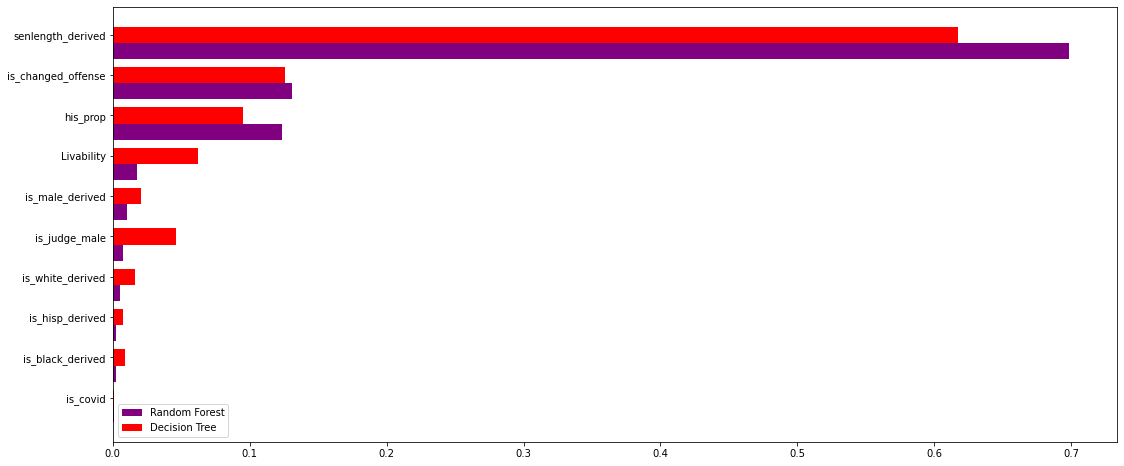

In [257]:
feature_importance1=pd.DataFrame({
    'rfc':forest.best_estimator_.feature_importances_,
    'dt':tree.best_estimator_.feature_importances_,
},index=sentencing_concat.drop(['Incar'], axis = 1).columns)
feature_importance1.sort_values(by='rfc',ascending=True,inplace=True)

index = np.arange(len(feature_importance1))
fig, ax = plt.subplots(figsize=(18,8))
rfc_feature=ax.barh(index,feature_importance1['rfc'],0.4,color='purple',label='Random Forest')
dt_feature=ax.barh(index+0.4,feature_importance1['dt'],0.4,color='red',label='Decision Tree')
ax.set(yticks=index+0.4,yticklabels=feature_importance1.index)

ax.legend()
plt.show()